In [ ]:
import kagglehub
path = kagglehub.dataset_download('abhi8923shriv/sentiment-analysis-dataset')

print('Data source import complete.')


100%|██████████| 54.4M/54.4M [00:00<00:00, 64.8MB/s]

Extracting files...


Data source import complete.


# Sentiment Analysis on Kaggle sentiment analysis dataset
sentiment analysis tasks on kaggle sentiment analysis dataset using simple machine learning model: Naive bayes


## Including needed libraries

In [ ]:
# --------------- MAIN LIBRARIES ------------------

import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split


# --------------- HELPING LIBRARIES ----------------
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# ------------- Pytorch Librairies ---------------
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
# from transformers import RobertaTokenizer, RobertaModel
from transformers import BertTokenizer, BertModel

## Uploading Data

In [ ]:
train_dataset = path+'/train.csv'
test_dataset = path+'/test.csv'

# Check if the path exists
print (os.path.exists(train_dataset))
print (os.path.exists(test_dataset))

True
True


In [ ]:
# Load the CSV file into a DataFrame
train_df = pd.read_csv(train_dataset, encoding='ISO-8859-1')
test_df = pd.read_csv(test_dataset, encoding='ISO-8859-1')


In [ ]:
train_df.head(2)

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105


In [ ]:
test_df.head(2)

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,noon,21-30,Albania,2877797.0,27400.0,105.0


## Data Preprocessing

#### Handling null values

In [ ]:
def handle_null_values(df, columns_to_keep=None):
    """
    Handle null values in a pandas DataFrame.
    If missing values are less than 5%, remove rows with missing values.
    If missing values are 5% or more, keep rows where specified columns are not empty.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    columns_to_keep (list): List of column names to prioritize when keeping rows.

    Returns:
    pd.DataFrame: The DataFrame with null values handled.
    """

    # Calculate the percentage of missing values in the DataFrame
    missing_percentage = df.isnull().mean().mean() * 100

    print(f"Percentage of missing values in the dataset: {missing_percentage:.4f}%")

    # If missing values are less than 5%, remove rows with missing values
    if missing_percentage < 5:
        print("Missing values are less than 5%. Removing rows with missing values...")
        df_cleaned = df.dropna()
        print(f"Number of rows removed: {len(df) - len(df_cleaned)}")
    else:
        print("Missing values are 5% or more. Keeping rows where specified columns are not empty...")
        if columns_to_keep is None:
            print("No columns specified to keep. Returning the original DataFrame.")
            df_cleaned = df
        else:
            # Keep rows where the specified columns are not null
            df_cleaned = df.dropna(subset=columns_to_keep)
            print(f"Number of rows removed: {len(df) - len(df_cleaned)}")

    return df_cleaned

In [ ]:
train_df = handle_null_values(train_df)

Percentage of missing values in the dataset: 0.0007%
Missing values are less than 5%. Removing rows with missing values...
Number of rows removed: 1


In [ ]:
test_df=handle_null_values(test_df,columns_to_keep=["text","sentiment"])

Percentage of missing values in the dataset: 26.6044%
Missing values are 5% or more. Keeping rows where specified columns are not empty...
Number of rows removed: 1281


#### Removing stopwords & lowercase all text

In [ ]:
# Download necessary NLTK data
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
my_stopwords = stopwords.words('english').copy()

In [ ]:
stopwords_to_keep = {
    'not', 'no', 'nor', "don't", "isn't", "aren't", "couldn't", "didn't", "doesn't",
    "hadn't", "hasn't", "haven't", "mightn't", "mustn't", "needn't", "shouldn't",
    "wasn't", "weren't", "won't", "wouldn't", 'but', 'however', 'although', 'though'
}

In [ ]:
my_stopwords = list(set(my_stopwords) - stopwords_to_keep)
my_stopwords

['doing',
 'after',
 'a',
 'was',
 'those',
 'between',
 'does',
 "you'd",
 'mightn',
 'from',
 'has',
 'while',
 'an',
 'having',
 'and',
 'both',
 'the',
 'very',
 'am',
 'against',
 'now',
 'here',
 'will',
 'further',
 'on',
 'shan',
 "she's",
 'these',
 "shan't",
 'weren',
 'who',
 'wasn',
 'what',
 'did',
 'm',
 'ain',
 'your',
 'she',
 'its',
 'o',
 'don',
 'my',
 'herself',
 'than',
 'where',
 'should',
 'him',
 'other',
 "you've",
 'yourself',
 'haven',
 "it's",
 'himself',
 'they',
 'few',
 'y',
 'then',
 'shouldn',
 'down',
 'too',
 'been',
 're',
 'being',
 'under',
 'some',
 'me',
 'didn',
 'ourselves',
 'which',
 'below',
 "that'll",
 'their',
 'are',
 'myself',
 'above',
 'each',
 'to',
 'ours',
 'have',
 'had',
 'in',
 'his',
 's',
 'so',
 'about',
 'hasn',
 'hers',
 'aren',
 've',
 'over',
 'isn',
 'i',
 'or',
 'out',
 'when',
 'be',
 'if',
 'is',
 'why',
 'were',
 'before',
 'off',
 'that',
 "you'll",
 'until',
 'only',
 'same',
 'more',
 'do',
 'through',
 'ma',
 'su

In [ ]:
import re

In [ ]:
print(re.sub(r'\s+', ' ', "testing how,  this goes!   lol ?    "))

testing how, this goes! lol ? 


In [ ]:
# Text preprocessing function that removes stopwords and convert text to lowercase

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    # stop_words = set(stopwords.words('english'))
    stop_words = my_stopwords
    text = " ".join([word for word in text.split() if word not in stop_words])
    text= re.sub(r'https?://[A-Za-z0-9./_?=#]+'," ",text) #supprimer les liens
    text = re.sub(r"[^a-zA-Z0-9\s!?*$]", "", text) # supprimer la ponctuation
    text = re.sub(r'\s+', ' ', text) # supprimer les doubles espaces
    return text



In [ ]:
# Apply preprocessing on train dataset
train_df['processed_text'] = train_df['text'].apply(preprocess_text)
train_df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²),processed_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60,id responded going
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105,sooo sad miss san diego!!!
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18,boss bullying me
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164,interview! leave alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26,sons **** couldnt put releases already bought


In [ ]:
# Apply preprocessing on test dataset
test_df['processed_text'] = test_df['text'].apply(preprocess_text)
test_df.head()

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²),processed_text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0,last session day
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,noon,21-30,Albania,2877797.0,27400.0,105.0,shanghai also really exciting precisely skyscr...
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,night,31-45,Algeria,43851044.0,2381740.0,18.0,recession hit veronique branquinho quit compan...
3,01082688c6,happy bday!,positive,morning,46-60,Andorra,77265.0,470.0,164.0,happy bday!
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,noon,60-70,Angola,32866272.0,1246700.0,26.0,like it!!


In [ ]:
# Transform sentiment into 3 classes
# Example mapping: positive -> 2, neutral -> 1, negative -> 0
sentiment_mapping = {"positive": 2, "neutral": 1, "negative": 0}
sentiment_reverse_mapping = {2: "positive",1:"neutral", 0:"negative"}
train_df["sentiment_class"] = train_df["sentiment"].map(sentiment_mapping)
test_df["sentiment_class"] = test_df["sentiment"].map(sentiment_mapping)



## Q0 : Exploratory Data Analysis | Classical methods

In [ ]:
# Filters
negatives=train_df['sentiment']=="negative"
positives=train_df['sentiment']=="positive"
neutrals = train_df["sentiment"]=="neutral"

###

In [ ]:
train_df["len"] = train_df["processed_text"].apply(lambda x: len(x.split()))

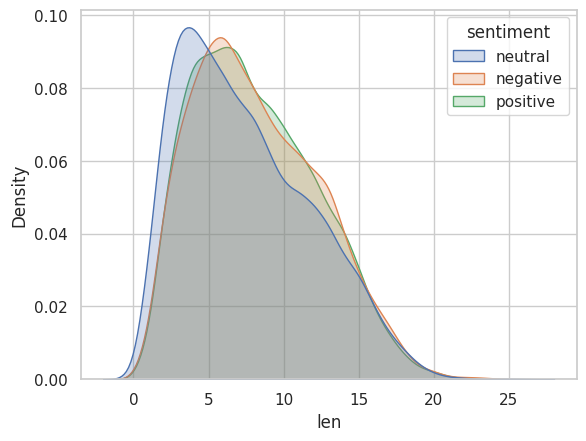

In [ ]:
sns.kdeplot(data=train_df,x="len",hue="sentiment",fill=True, common_norm=False)
plt.show()

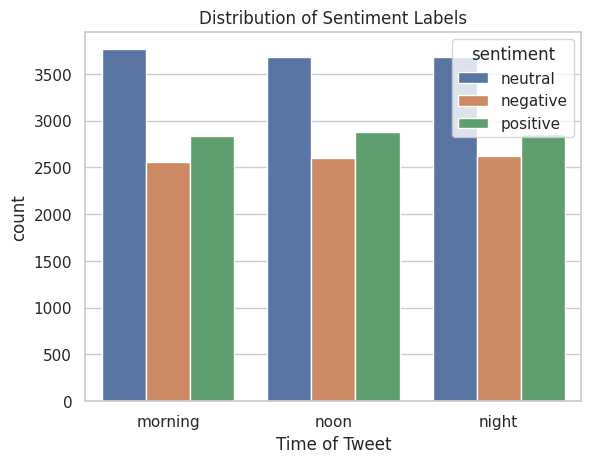

In [ ]:
sns.countplot(x='Time of Tweet', data=train_df, hue="sentiment")
plt.title("Distribution of Sentiment Labels")
plt.show()

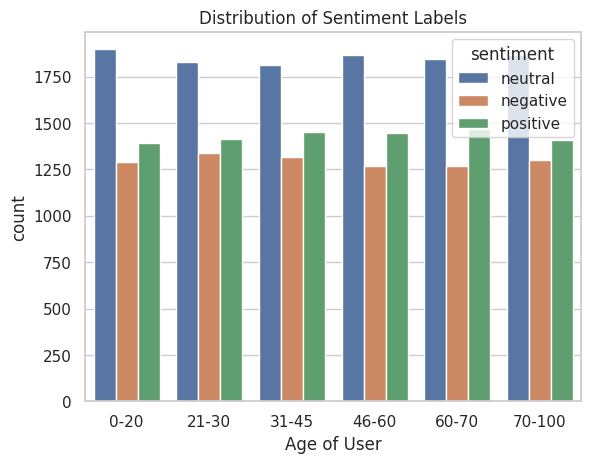

In [ ]:
sns.countplot(x='Age of User', data=train_df, hue="sentiment")
plt.title("Distribution of Sentiment Labels")
plt.show()

In [ ]:
from collections import Counter
top_pos =Counter(" ".join(train_df[positives]['processed_text']).split())
top_pos_df=pd.DataFrame(top_pos.most_common(100),columns=['Words','Counts'])

top_neg = Counter(" ".join(train_df[negatives]['processed_text']).split())
top_neg_df=pd.DataFrame(top_neg.most_common(100),columns=['Words','Counts'])

top_neu = Counter(" ".join(train_df[neutrals]['processed_text']).split())
top_neu_df=pd.DataFrame(top_neu.most_common(100),columns=['Words','Counts'])

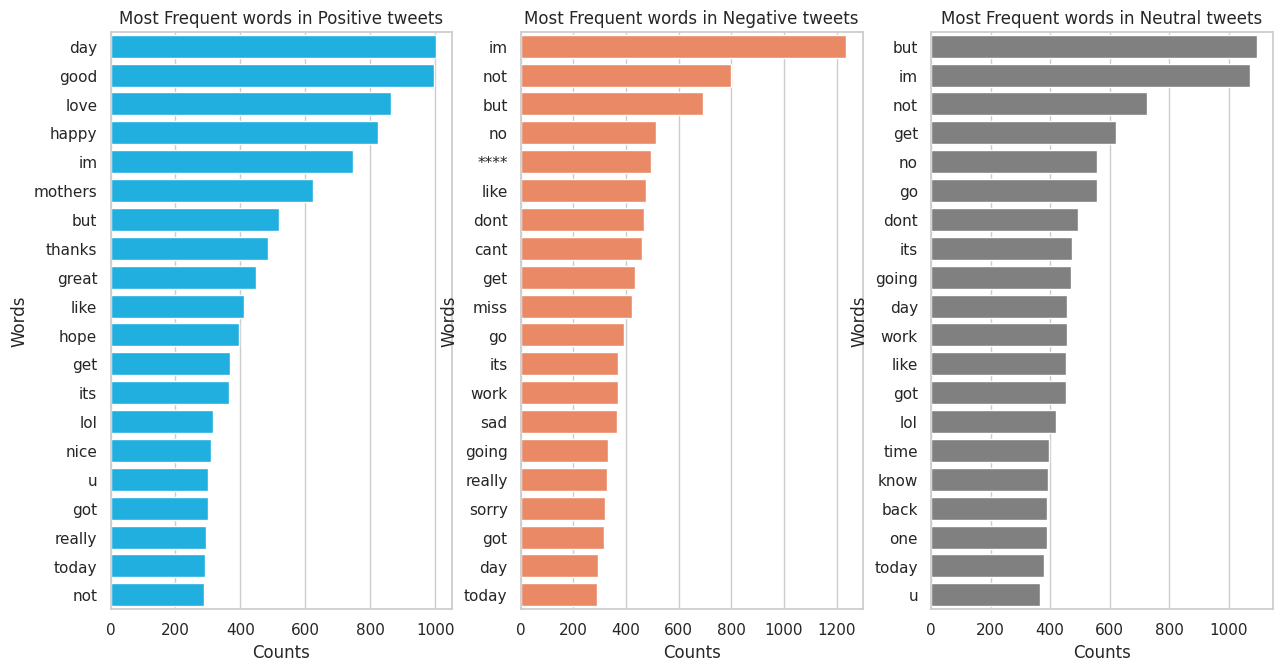

In [ ]:
fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(15,7.5))
sns.barplot(y='Words',x='Counts',data=top_pos_df[:20],color='deepskyblue',ax=ax[0])
sns.barplot(y='Words',x='Counts',data=top_neg_df[:20],color='coral',ax=ax[1])
sns.barplot(y='Words',x='Counts',data=top_neu_df[:20],color='grey',ax=ax[2])
ax[0].set_title("Most Frequent words in Positive tweets")
ax[1].set_title("Most Frequent words in Negative tweets")
ax[2].set_title("Most Frequent words in Neutral tweets")
plt.show()

## Check Imbalancing

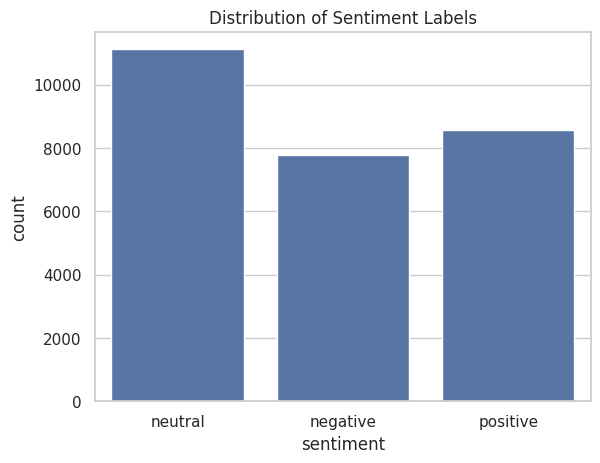

In [ ]:
# Distribution of sentiment labels
sns.countplot(x='sentiment', data=train_df)
plt.title("Distribution of Sentiment Labels")
plt.show()

## Splitting the Data


In [ ]:
# Extract all the values from the 'processed_text' column into a list
trainval_x = train_df["processed_text"].tolist()
trainval_y = train_df["sentiment_class"].tolist()

train_x, val_x, train_y, val_y = train_test_split(trainval_x, trainval_y, test_size=0.2, random_state=1770)

test_x = test_df["processed_text"].tolist()
test_y = test_df["sentiment_class"].tolist()

### Applying TF_IDF vectorization on classical ML models

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import  accuracy_score

In [ ]:
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=5,  # Ignorer les termes qui apparaissent dans moins de 5 documents
    max_df=0.95)
X_train_tfidf = tfidf.fit_transform(train_df['processed_text'])
X_test_tfidf = tfidf.transform(test_df['processed_text'])
models = {
    'Logistic Regression': LogisticRegression(
        multi_class='multinomial',  # Spécifique pour multiclasse
        solver='lbfgs',
        max_iter=1000,
        class_weight='balanced'
    ),
    'Naive Bayes': MultinomialNB(alpha=0.1),  # Ajout d'un smoothing parameter
    'Linear SVM': LinearSVC(
        multi_class='ovr',  # one-vs-rest
        max_iter=1000,
        class_weight='balanced'
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',
        max_depth=10  # Limiter la profondeur pour éviter le surapprentissage
    )
}
results_tf = {}
for name, model in models.items():

    model.fit(X_train_tfidf, train_df["sentiment_class"])

    y_pred = model.predict(X_test_tfidf)

    accuracy = accuracy_score(test_df["sentiment_class"], y_pred)
    results_tf[name] = {
        'accuracy': accuracy,
    }
for name in models.keys():
        print(f"\nRésultats pour {name}:")
        print(f"Accuracy: {results_tf[name]['accuracy']:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Résultats pour Logistic Regression:
Accuracy: 0.7060

Résultats pour Naive Bayes:
Accuracy: 0.6344

Résultats pour Linear SVM:
Accuracy: 0.6930

Résultats pour Random Forest:
Accuracy: 0.6559


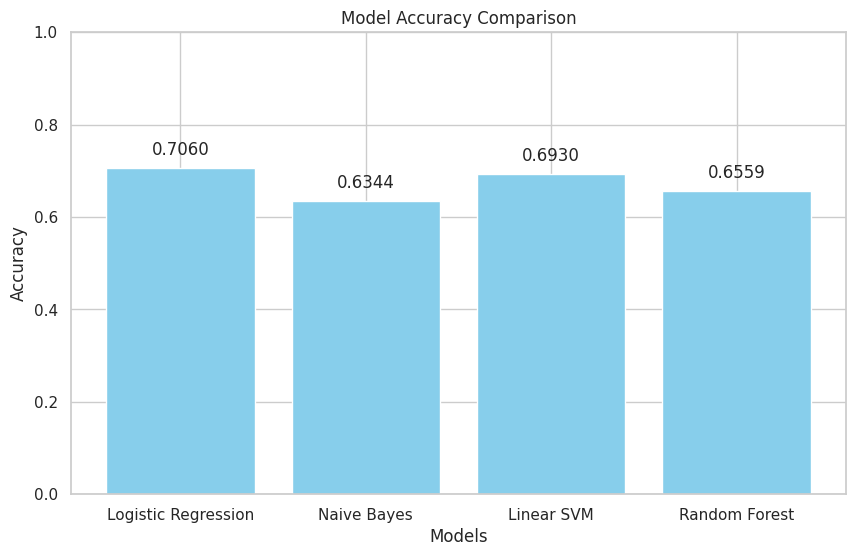

In [ ]:
model_names = list(results_tf.keys())
accuracies = [results_tf[name]["accuracy"] for name in model_names]

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color="skyblue")

# Add labels and title
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0, 1)  # Set y-axis limit between 0 and 1 for accuracy

# Add accuracy values on top of the bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f"{acc:.4f}", ha="center", va="bottom")

# Show the plot
plt.show()

In [ ]:
print(len(trainval_x),len(val_x),len(test_x))

27480 5496 3534


### Loading the dataset into pytorch Dataset with embeddings

In [ ]:
from tqdm import tqdm
class TextDatasetWithEmbeddings(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length, model, device):
        """
        Args:
            texts (list): List of text samples.
            labels (list): List of labels.
            tokenizer (transformers.BertTokenizer): BERT tokenizer.
            max_length (int): Maximum sequence length.
            model (transformers.BertModel): Pre-trained BERT model.
            device (torch.device): Device (CPU/GPU).
            use_pooler (bool): If True, use `pooler_output`; else, use `last_hidden_state[:, 0, :]`.
        """
        self.texts = texts
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.model = model
        self.device = device

        # Tokenize all texts upfront
        self.encodings = self.tokenizer(
            texts,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )

        # Precompute embeddings for all texts
        self.embeddings = self._precompute_embeddings()

    def _precompute_embeddings(self, batch_size=512):
        """Generates embeddings in batches to avoid GPU memory overload."""
        print("Generating embeddings in batches...")
        self.model.eval()
        self.model.to(self.device)

        # Get total number of samples
        num_samples = self.encodings["input_ids"].size(0)

        # Initialize tensor to store all embeddings
        all_embeddings = []

        # Process in batches
        for start_idx in tqdm(range(0, num_samples, batch_size)):
            end_idx = min(start_idx + batch_size, num_samples)

            # Get batch
            batch_input_ids = self.encodings["input_ids"][start_idx:end_idx].to(self.device)
            batch_attention_mask = self.encodings["attention_mask"][start_idx:end_idx].to(self.device)

            with torch.no_grad():
                outputs = self.model(
                    input_ids=batch_input_ids,
                    attention_mask=batch_attention_mask
                )
                batch_embeddings = outputs.pooler_output
            all_embeddings.append(batch_embeddings.cpu())

        # Combine all batches
        return torch.cat(all_embeddings, dim=0)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        """Returns precomputed embeddings and labels."""
        return self.embeddings[idx], self.labels[idx]

### Loading the dataset into pytorch Dataset with tokens only (for finetuning and Lora)

In [ ]:
class TokenizedDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.encodings = tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}, self.labels[idx]


### initializations of datasets/dataloaders

In [ ]:
MAX_LENGTH = 128
PRETRAINED_MODEL = "bert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL)
bert = BertModel.from_pretrained(PRETRAINED_MODEL).to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

#### Tokenized Dataset

In [ ]:
train_dataset_tokenized = TokenizedDataset(train_x, train_y, tokenizer, MAX_LENGTH)
val_dataset_tokenized = TokenizedDataset(val_x, val_y, tokenizer, MAX_LENGTH)
test_dataset_tokenized = TokenizedDataset(test_x, test_y, tokenizer, MAX_LENGTH)

#### Embedded Dataset

In [ ]:
train_dataset_embed =  TextDatasetWithEmbeddings(
        texts=train_x,
        labels=train_y,
        tokenizer=tokenizer,
        max_length=MAX_LENGTH,
        model=bert,
        device=device
    )

val_dataset_embed = TextDatasetWithEmbeddings(
        texts=val_x,
        labels=val_y,
        tokenizer=tokenizer,
        max_length=MAX_LENGTH,
        model=bert,
        device=device
    )

test_dataset_embed = TextDatasetWithEmbeddings(
        texts=test_x,
        labels=test_y,
        tokenizer=tokenizer,
        max_length=MAX_LENGTH,
        model=bert,
        device=device
    )


Generating embeddings in batches...


100%|██████████| 43/43 [02:12<00:00,  3.07s/it]


Generating embeddings in batches...


100%|██████████| 11/11 [00:34<00:00,  3.12s/it]


Generating embeddings in batches...


100%|██████████| 7/7 [00:23<00:00,  3.34s/it]


In [ ]:
# Batch size
BATCH_SIZE_TRAIN = 64
BATCH_SIZE_TEST = 256

#### Tokenized Dataloader

In [ ]:
train_loader_tokenized = DataLoader(train_dataset_tokenized
, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
valloader_tokenized = DataLoader(val_dataset_tokenized, batch_size=BATCH_SIZE_TEST, shuffle=True)
testloader_tokenized = DataLoader(test_dataset_tokenized, batch_size = BATCH_SIZE_TEST,shuffle=False)

#### Embedded Dataloader

In [ ]:
trainloader_embed = DataLoader(train_dataset_embed
, batch_size=BATCH_SIZE_TRAIN, shuffle=True)


valloader_embed = DataLoader(val_dataset_embed, batch_size=BATCH_SIZE_TEST, shuffle=True)


testloader_embed = DataLoader(test_dataset_embed, batch_size = BATCH_SIZE_TEST,shuffle=False)


In [ ]:
print("lolqsdqs1")

lolqsdqs1


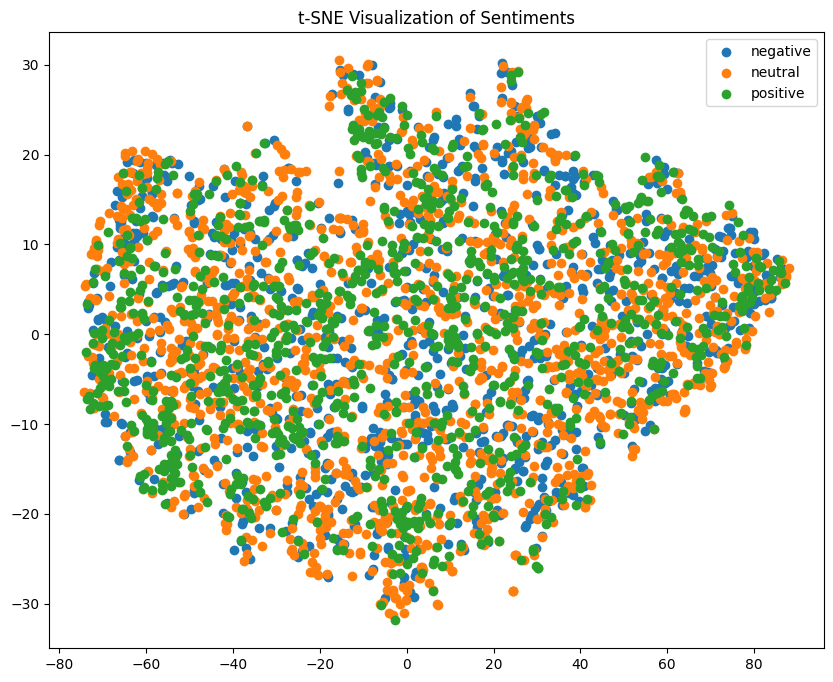

In [ ]:
# prompt: use tsne to plot different sentiments based on the embeddings test_dataset.embeddings.numpy() and labels .labels()

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assuming test_dataset.embeddings.numpy() and test_dataset.labels() are defined

embeddings = test_dataset_embed.embeddings.numpy()
labels = test_dataset_embed.labels.numpy()  # Assuming labels() is a method

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
for label in np.unique(labels):
    indices = np.where(labels == label)
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=sentiment_reverse_mapping[label])

plt.legend()
plt.title('t-SNE Visualization of Sentiments')
plt.show()

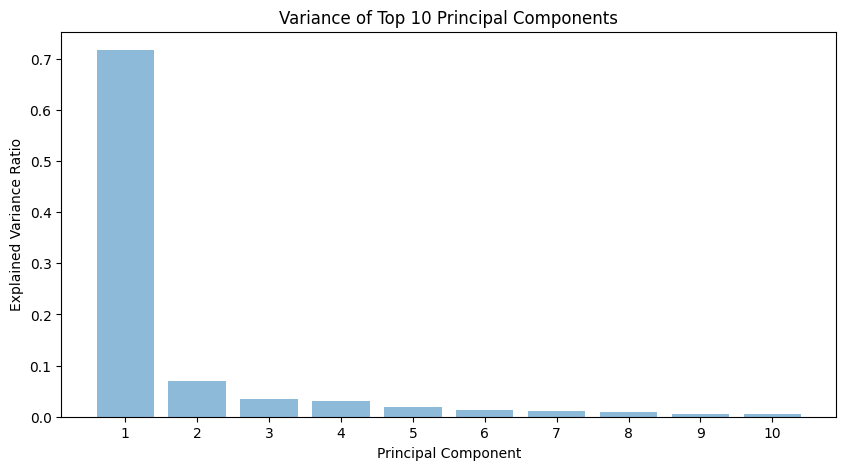

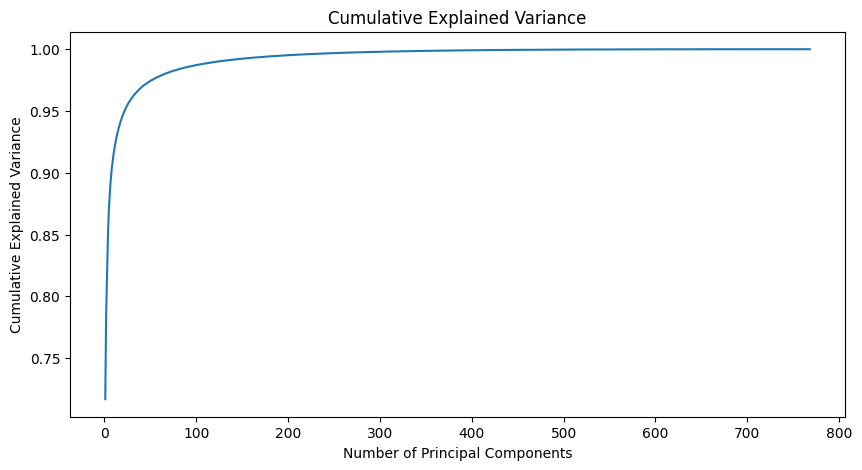

In [ ]:
# prompt: PCA decomposition , bar plot variance of top 10 components and cumulative explained variance

import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Assuming 'embeddings' is your data (replace with your actual data)
embeddings = test_dataset_embed.embeddings.numpy()

# Apply PCA
pca = PCA()
pca_result = pca.fit_transform(embeddings)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Plot variance of top 10 components
plt.figure(figsize=(10, 5))
plt.bar(range(1, 11), explained_variance_ratio[:10], alpha=0.5, align='center')
plt.xticks(range(1, 11))
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Variance of Top 10 Principal Components')
plt.show()

# Cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot cumulative explained variance
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.show()

## Q1 : Classification using ML models (with BERT embeddings)

In [ ]:
# Function to test the ML models
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.patches as patches

# def test_ml_model(model, test_dataset=test_dataset_embed, validation_dataset=val_dataset_embed):
#     # Make predictions
#     test_label_pred = model.predict(test_dataset.embeddings.numpy())
#     validation_label_pred = model.predict(validation_dataset.embeddings.numpy())

#     # Compute confusion matrices
#     cm_test = confusion_matrix(test_dataset.labels.numpy(), test_label_pred)
#     cm_validation = confusion_matrix(validation_dataset.labels.numpy(), validation_label_pred)

#     # Set up the subplots
#     fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

#     # Plot test confusion matrix
#     sns.heatmap(cm_test, annot=True, fmt="d", cbar=True,
#                 xticklabels=list(sentiment_reverse_mapping.values()),
#                 yticklabels=list(sentiment_reverse_mapping.values()), ax=axes[0])
#     axes[0].set_title("Test Confusion Matrix")
#     axes[0].set_xlabel("Predicted Labels")
#     axes[0].set_ylabel("True Labels")

#     # Highlight the diagonal (correct predictions) for test set
#     for i in range(cm_test.shape[0]):
#         axes[0].add_patch(patches.Rectangle((i, i), 1, 1, fill=False, edgecolor="Coral", linewidth=2))

#     # Plot validation confusion matrix
#     sns.heatmap(cm_validation, annot=True, fmt="d", cbar=True,
#                 xticklabels=list(sentiment_reverse_mapping.values()),
#                 yticklabels=list(sentiment_reverse_mapping.values()), ax=axes[1])
#     axes[1].set_title("Validation Confusion Matrix")
#     axes[1].set_xlabel("Predicted Labels")
#     axes[1].set_ylabel("True Labels")

#     # Highlight the diagonal (correct predictions) for validation set
#     for i in range(cm_validation.shape[0]):
#         axes[1].add_patch(patches.Rectangle((i, i), 1, 1, fill=False, edgecolor="Coral", linewidth=2))

#     # Show the plot
#     plt.tight_layout()
#     plt.show()

#     # Print classification reports for both test and validation
#     print("Test Classification Report:")
#     print(f"Overall Score {(model.score(test_dataset.embeddings.numpy(),test_dataset.labels.numpy())*100):.2f}%")
#     print(classification_report(test_dataset.labels.numpy(), test_label_pred))

#     print("Validation Classification Report:")
#     print(f"Overall Score {(model.score(validation_dataset.embeddings.numpy(),validation_dataset.labels.numpy())*100):.2f}%")
#     print(classification_report(validation_dataset.labels.numpy(), validation_label_pred))

def test_ml_model(model, model_name, test_dataset=test_dataset_embed, validation_dataset=val_dataset_embed):
    # Make predictions
    test_label_pred = model.predict(test_dataset.embeddings.numpy())
    validation_label_pred = model.predict(validation_dataset.embeddings.numpy())

    # Compute confusion matrices
    cm_test = confusion_matrix(test_dataset.labels.numpy(), test_label_pred)
    cm_validation = confusion_matrix(validation_dataset.labels.numpy(), validation_label_pred)

    # Set up the subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

    # Plot test confusion matrix
    sns.heatmap(cm_test, annot=True, fmt="d", cbar=True,
                xticklabels=list(sentiment_reverse_mapping.values()),
                yticklabels=list(sentiment_reverse_mapping.values()), ax=axes[0])
    axes[0].set_title("Test Confusion Matrix")
    axes[0].set_xlabel("Predicted Labels")
    axes[0].set_ylabel("True Labels")

    # Highlight the diagonal (correct predictions) for test set
    for i in range(cm_test.shape[0]):
        axes[0].add_patch(patches.Rectangle((i, i), 1, 1, fill=False, edgecolor="Coral", linewidth=2))

    # Plot validation confusion matrix
    sns.heatmap(cm_validation, annot=True, fmt="d", cbar=True,
                xticklabels=list(sentiment_reverse_mapping.values()),
                yticklabels=list(sentiment_reverse_mapping.values()), ax=axes[1])
    axes[1].set_title("Validation Confusion Matrix")
    axes[1].set_xlabel("Predicted Labels")
    axes[1].set_ylabel("True Labels")

    # Highlight the diagonal (correct predictions) for validation set
    for i in range(cm_validation.shape[0]):
        axes[1].add_patch(patches.Rectangle((i, i), 1, 1, fill=False, edgecolor="Coral", linewidth=2))

    # Show the plot
    plt.tight_layout()
    plt.show()

    # Get classification report as dictionary
    test_report = classification_report(test_dataset.labels.numpy(), test_label_pred, output_dict=True)
    validation_report = classification_report(validation_dataset.labels.numpy(), validation_label_pred, output_dict=True)

    # Print classification reports
    print("Test Classification Report:")
    print(f"Overall Score {(model.score(test_dataset.embeddings.numpy(), test_dataset.labels.numpy()) * 100):.2f}%")
    print(classification_report(test_dataset.labels.numpy(), test_label_pred))

    print("Validation Classification Report:")
    print(f"Overall Score {(model.score(validation_dataset.embeddings.numpy(), validation_dataset.labels.numpy()) * 100):.2f}%")
    print(classification_report(validation_dataset.labels.numpy(), validation_label_pred))

    # Extract key metrics
    metrics = {
        "model_name": model_name,
        "test_accuracy": test_report["accuracy"],
        "test_precision": test_report["weighted avg"]["precision"],
        "test_recall": test_report["weighted avg"]["recall"],
        "test_f1-score": test_report["weighted avg"]["f1-score"],
        "validation_accuracy": validation_report["accuracy"],
        "validation_precision": validation_report["weighted avg"]["precision"],
        "validation_recall": validation_report["weighted avg"]["recall"],
        "validation_f1-score": validation_report["weighted avg"]["f1-score"],
    }

    return metrics

In [ ]:
results = []

### Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(train_dataset_embed.embeddings.numpy(),train_dataset_embed.labels.numpy())

DecisionTreeClassifier(random_state=42)

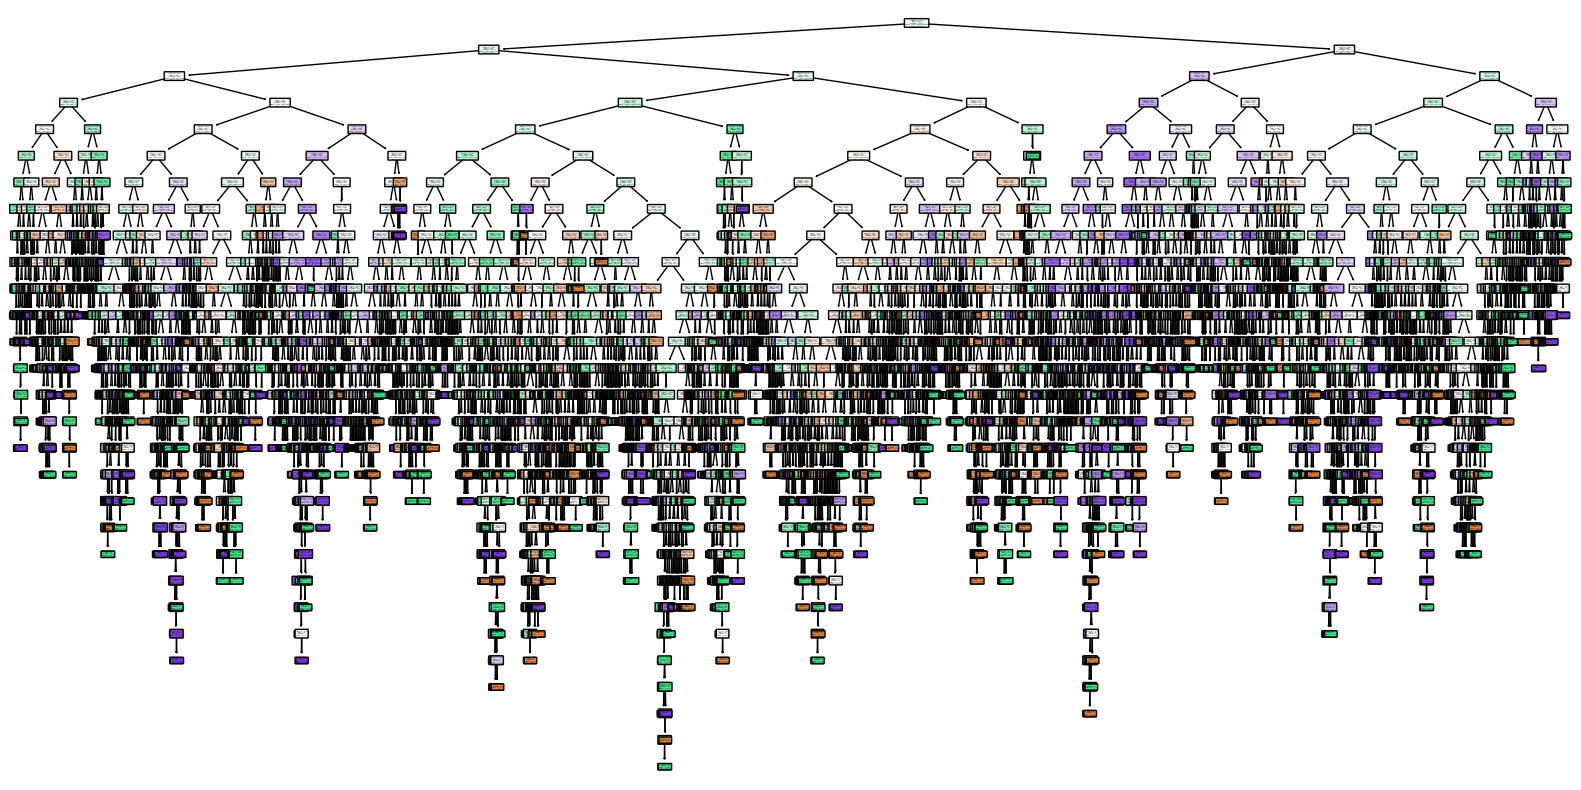

In [ ]:


from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(dt, filled=True, feature_names=None, class_names=['negative', 'neutral', 'positive'], rounded=True)
plt.show()

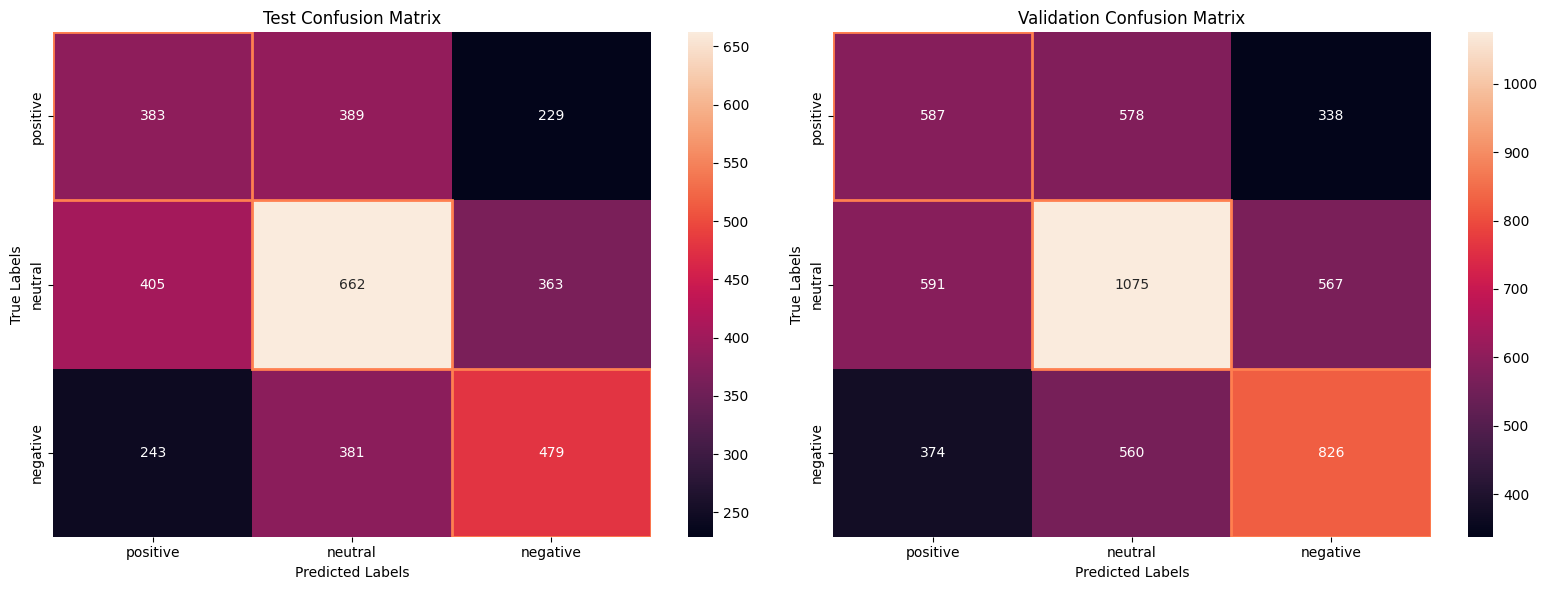

Test Classification Report:
Overall Score 43.12%
              precision    recall  f1-score   support

           0       0.37      0.38      0.38      1001
           1       0.46      0.46      0.46      1430
           2       0.45      0.43      0.44      1103

    accuracy                           0.43      3534
   macro avg       0.43      0.43      0.43      3534
weighted avg       0.43      0.43      0.43      3534

Validation Classification Report:
Overall Score 45.27%
              precision    recall  f1-score   support

           0       0.38      0.39      0.38      1503
           1       0.49      0.48      0.48      2233
           2       0.48      0.47      0.47      1760

    accuracy                           0.45      5496
   macro avg       0.45      0.45      0.45      5496
weighted avg       0.45      0.45      0.45      5496



In [ ]:
results.append(test_ml_model(dt,"Decision Tree"))

### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100,random_state=42,verbose = True)
rf.fit(train_dataset_embed.embeddings.numpy(),train_dataset_embed.labels.numpy())


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   39.5s


RandomForestClassifier(random_state=42, verbose=True)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


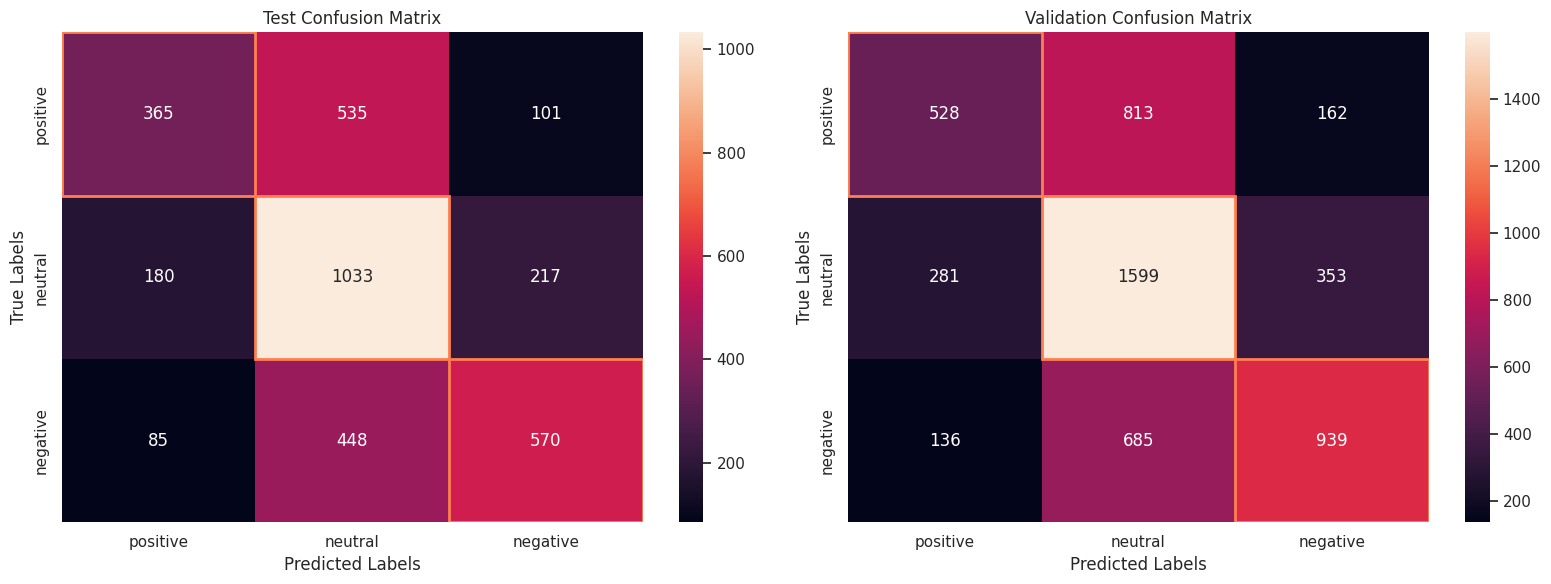

Test Classification Report:
Overall Score 55.69%
              precision    recall  f1-score   support

           0       0.58      0.36      0.45      1001
           1       0.51      0.72      0.60      1430
           2       0.64      0.52      0.57      1103

    accuracy                           0.56      3534
   macro avg       0.58      0.53      0.54      3534
weighted avg       0.57      0.56      0.55      3534

Validation Classification Report:


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


Overall Score 55.79%
              precision    recall  f1-score   support

           0       0.56      0.35      0.43      1503
           1       0.52      0.72      0.60      2233
           2       0.65      0.53      0.58      1760

    accuracy                           0.56      5496
   macro avg       0.57      0.53      0.54      5496
weighted avg       0.57      0.56      0.55      5496



In [ ]:
results.append(test_ml_model(rf,"Random Forest"))

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import GridSearchCV
# param_grid = {'C': [0.001,0.01,0.1,1,2,3]}

LR = LogisticRegression(max_iter=1000)
LR.fit(train_dataset_embed.embeddings.numpy(),train_dataset_embed.labels.numpy())
# grid_search = GridSearchCV(estimator=LR, param_grid=param_grid)
# grid_search.fit(train_dataset_embed.embeddings.numpy(),train_dataset_embed.labels.numpy())
# LR= grid_search.best_estimator_
# print(grid_search.best_params_["C"])

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [ ]:
# grid_search.best_params_

{'C': 1}

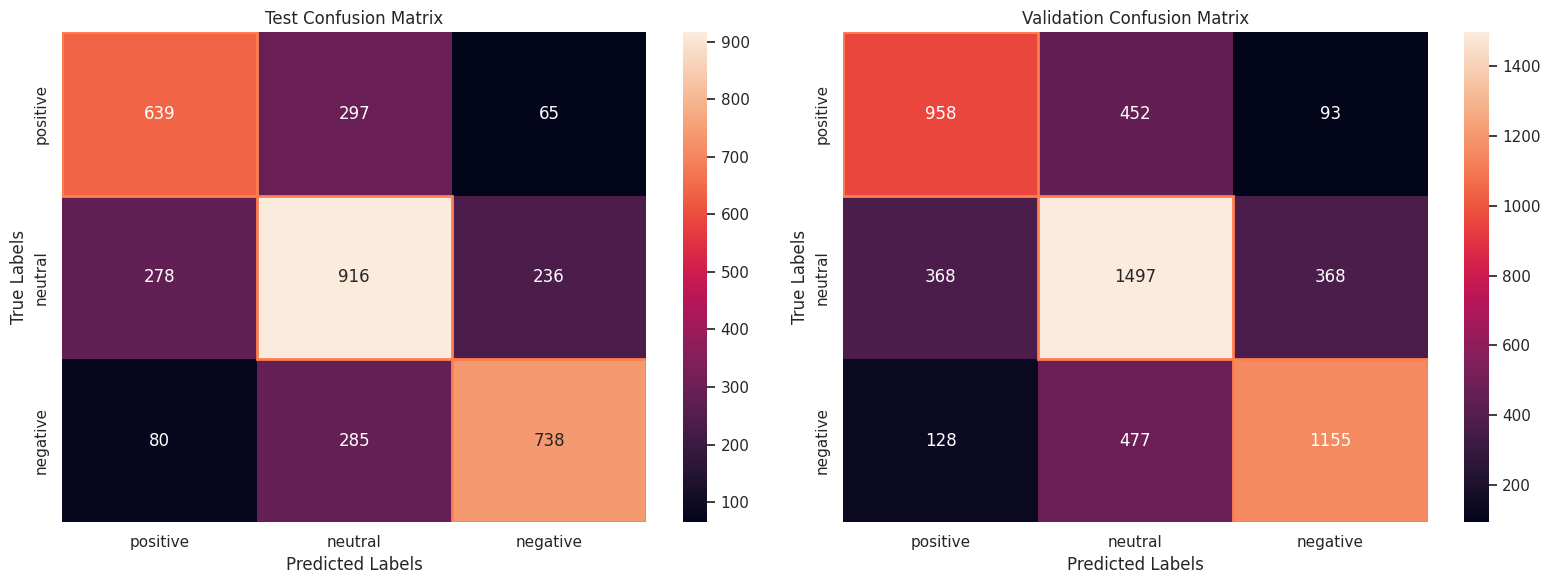

Test Classification Report:
Overall Score 64.88%
              precision    recall  f1-score   support

           0       0.64      0.64      0.64      1001
           1       0.61      0.64      0.63      1430
           2       0.71      0.67      0.69      1103

    accuracy                           0.65      3534
   macro avg       0.65      0.65      0.65      3534
weighted avg       0.65      0.65      0.65      3534

Validation Classification Report:
Overall Score 65.68%
              precision    recall  f1-score   support

           0       0.66      0.64      0.65      1503
           1       0.62      0.67      0.64      2233
           2       0.71      0.66      0.68      1760

    accuracy                           0.66      5496
   macro avg       0.66      0.65      0.66      5496
weighted avg       0.66      0.66      0.66      5496



In [ ]:
results.append(test_ml_model(LR,"Logistic Regression"))

### KNeighbores Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=30)
knn.fit(train_dataset_embed.embeddings.numpy(),train_dataset_embed.labels.numpy())

KNeighborsClassifier(n_neighbors=30)

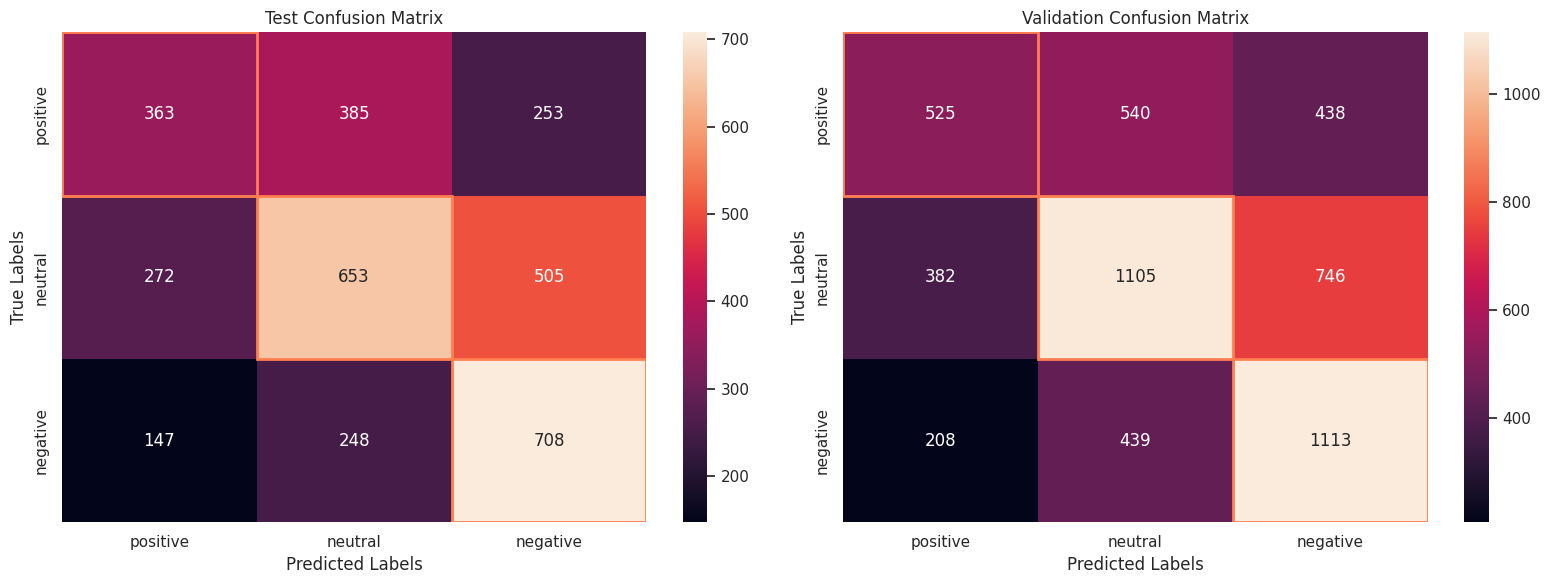

Test Classification Report:
Overall Score 48.78%
              precision    recall  f1-score   support

           0       0.46      0.36      0.41      1001
           1       0.51      0.46      0.48      1430
           2       0.48      0.64      0.55      1103

    accuracy                           0.49      3534
   macro avg       0.48      0.49      0.48      3534
weighted avg       0.49      0.49      0.48      3534

Validation Classification Report:
Overall Score 49.91%
              precision    recall  f1-score   support

           0       0.47      0.35      0.40      1503
           1       0.53      0.49      0.51      2233
           2       0.48      0.63      0.55      1760

    accuracy                           0.50      5496
   macro avg       0.50      0.49      0.49      5496
weighted avg       0.50      0.50      0.49      5496



In [ ]:
results.append(test_ml_model(knn,"KNeighbors(k=30)"))

### Gaussian Naive Bayes classifier

In [ ]:
from sklearn.naive_bayes import GaussianNB
GNB  =  GaussianNB(var_smoothing=1e-2)
GNB .fit(train_dataset_embed.embeddings.numpy(),train_dataset_embed.labels.numpy())

GaussianNB(var_smoothing=0.01)

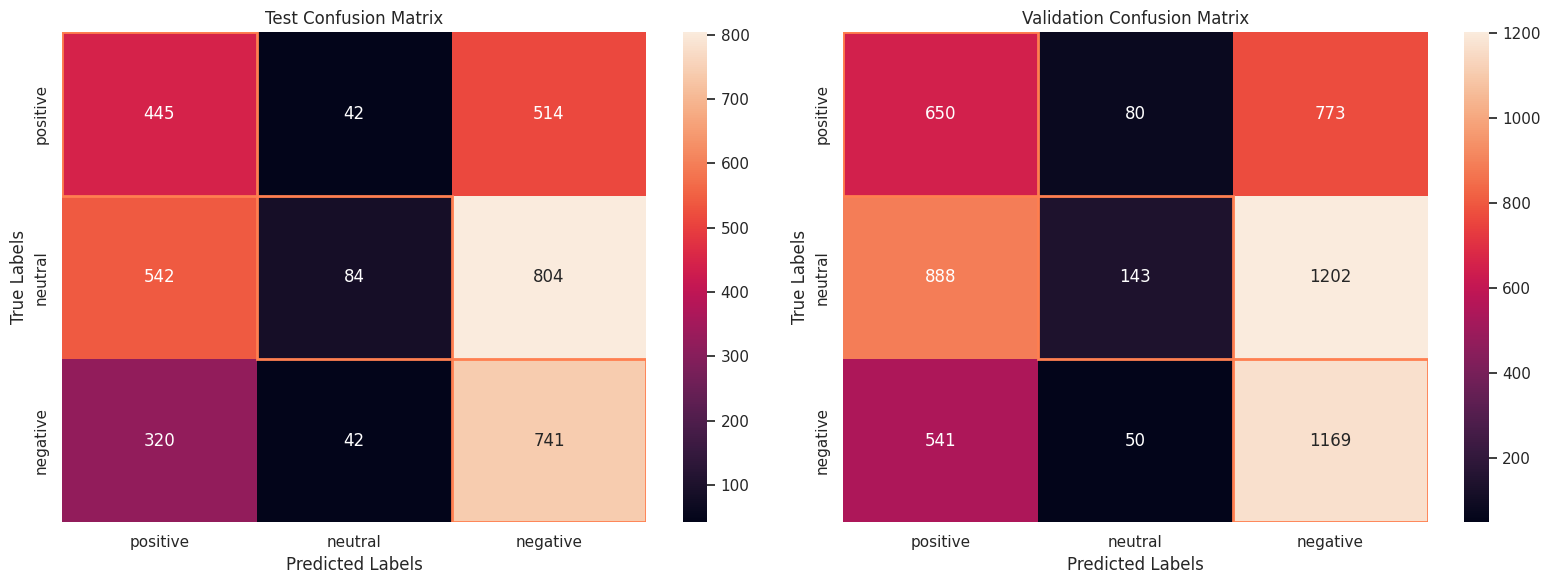

Test Classification Report:
Overall Score 35.94%
              precision    recall  f1-score   support

           0       0.34      0.44      0.39      1001
           1       0.50      0.06      0.11      1430
           2       0.36      0.67      0.47      1103

    accuracy                           0.36      3534
   macro avg       0.40      0.39      0.32      3534
weighted avg       0.41      0.36      0.30      3534

Validation Classification Report:
Overall Score 35.70%
              precision    recall  f1-score   support

           0       0.31      0.43      0.36      1503
           1       0.52      0.06      0.11      2233
           2       0.37      0.66      0.48      1760

    accuracy                           0.36      5496
   macro avg       0.40      0.39      0.32      5496
weighted avg       0.42      0.36      0.30      5496



In [ ]:
results.append(test_ml_model(GNB, "Gaussian Naive Bayes"))

### ML results

In [ ]:
df_results = pd.DataFrame(results)

In [ ]:
df_results

,model_name,test_accuracy,test_precision,test_recall,test_f1-score,validation_accuracy,validation_precision,validation_recall,validation_f1-score
0,Decision Tree,0.431239,0.431874,0.431239,0.431504,0.452693,0.453606,0.452693,0.453108
1,Random Forest,0.556876,0.571784,0.556876,0.548080,0.557860,0.569378,0.557860,0.548863
2,Logistic Regression,0.648840,0.650663,0.648840,0.649422,0.656841,0.659773,0.656841,0.657410
3,KNeighbors(k=30),0.487832,0.487682,0.487832,0.481937,0.499090,0.499362,0.499090,0.493382
4,Gaussian Naive Bayes,0.359366,0.411083,0.359366,0.298049,0.356987,0.417391,0.356987,0.298291


In [ ]:

import seaborn as sns


def plot_model_metrics(df_results):
    sns.set_theme(style="whitegrid")  # Use a clean style

    fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # 2 rows, 4 columns

    metrics = ["accuracy", "precision", "recall", "f1-score"]
    titles = ["Accuracy", "Precision", "Recall", "F1-Score"]
    colors = sns.color_palette("deep", 4)  # Seaborn color palette

    for i, metric in enumerate(metrics):
        # Test Metrics
        sns.barplot(x="model_name", y=f"test_{metric}", data=df_results, ax=axes[0, i], color=colors[i])
        axes[0, i].set_title(f"Test {titles[i]}", fontsize=14)
        axes[0, i].set_ylim(0, 1)
        axes[0, i].set_ylabel("Score")
        axes[0, i].set_xticklabels(df_results["model_name"], rotation=90,fontsize= 10)

        # Validation Metrics
        sns.barplot(x="model_name", y=f"validation_{metric}", data=df_results, ax=axes[1, i], color=colors[i])
        axes[1, i].set_title(f"Validation {titles[i]}", fontsize=14)
        axes[1, i].set_ylim(0, 1)
        axes[1, i].set_ylabel("Score")
        axes[1, i].set_xticklabels(df_results["model_name"], rotation=90,fontsize = 10)

    fig.suptitle("Model Performance Comparison", fontsize=18, fontweight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout for title
    plt.show()
    best_model = df_results.loc[df_results["test_accuracy"].idxmax()]
    print(f"The best model is {best_model['model_name']} with a test accuracy of {best_model['test_accuracy'] * 100:.2f}%")




<ipython-input-75-16af854e97c8>:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, i].set_xticklabels(df_results["model_name"], rotation=45)
<ipython-input-75-16af854e97c8>:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, i].set_xticklabels(df_results["model_name"], rotation=45)
<ipython-input-75-16af854e97c8>:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, i].set_xticklabels(df_results["model_name"], rotation=45)
<ipython-input-75-16af854e97c8>:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, i].set_xticklabels(df_results["model_name"], rotation=45)
<ipython-input-75-16af854e97c8>:19: UserWarning: set_ticklabels() should

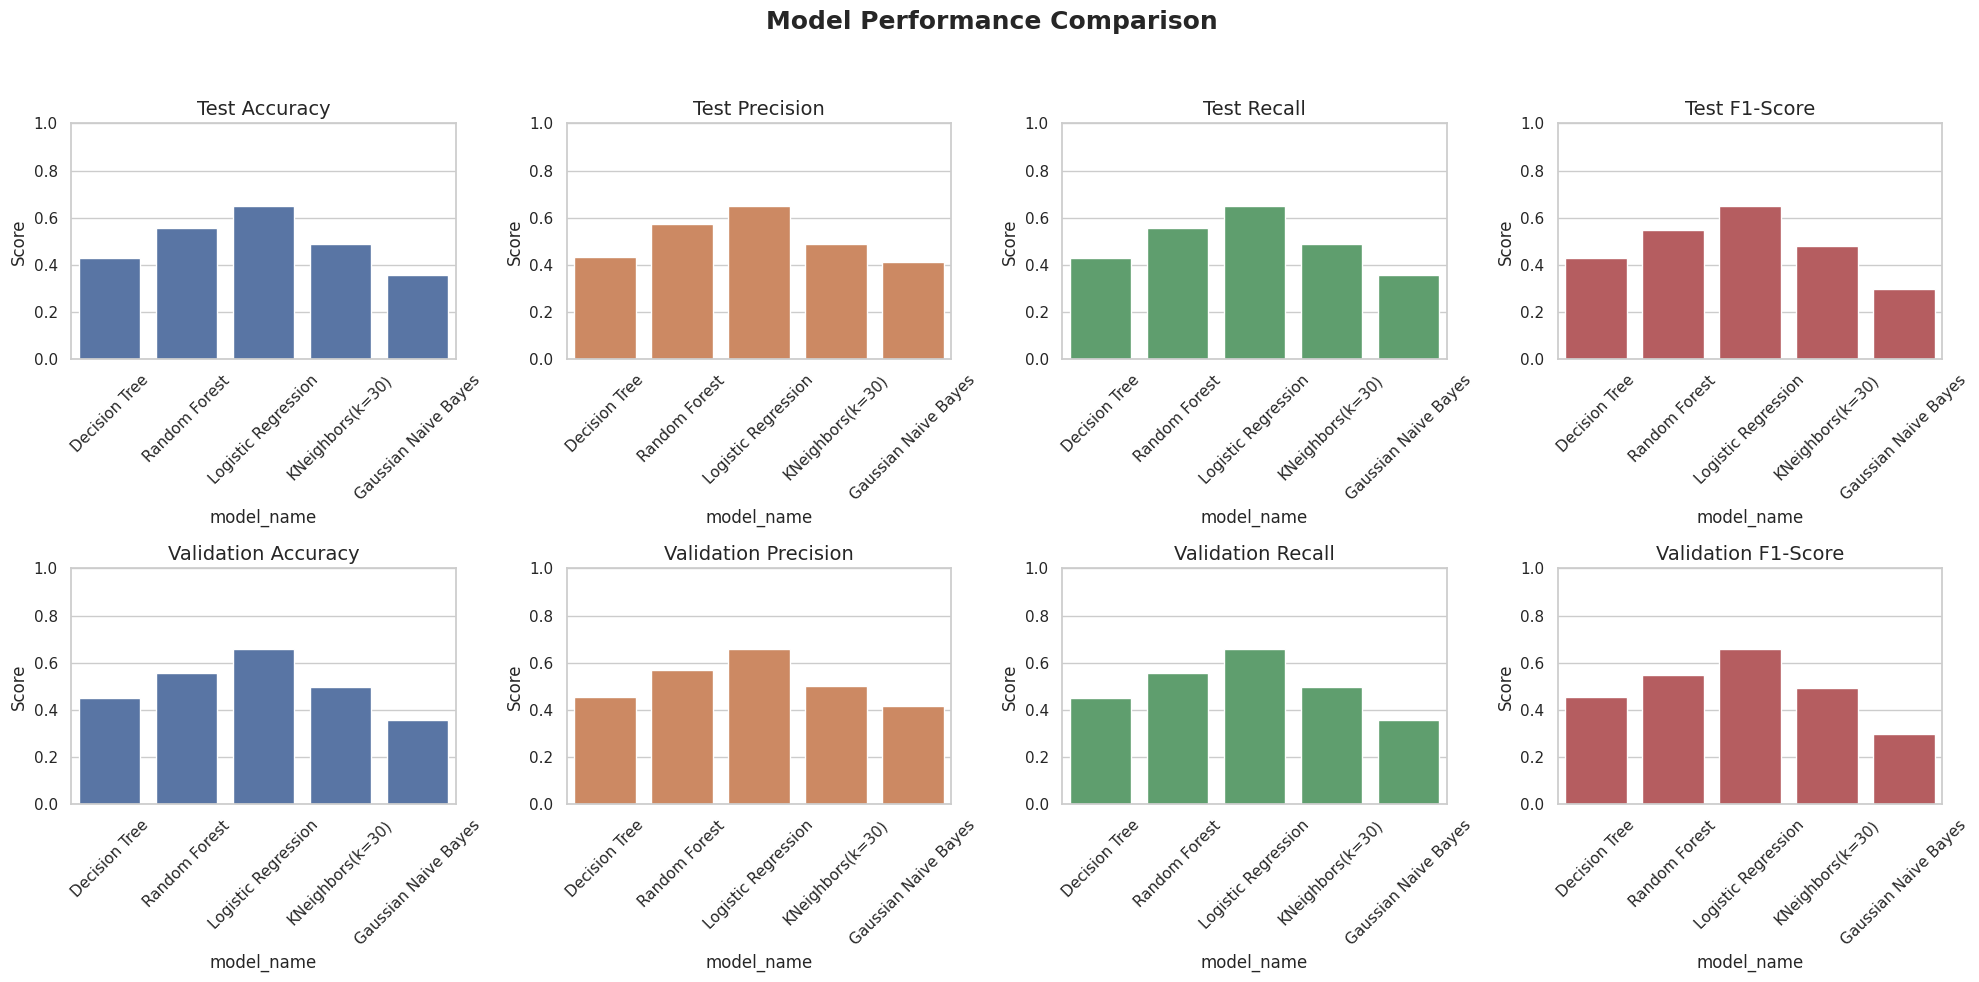

In [ ]:
plot_model_metrics(df_results)

## Q3 Deep learning : MLP model with embedded text as input

### MLP Architecture

In [ ]:

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.BatchNorm1d(input_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
             nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.05),
            nn.Linear(128, output_dim)
        )
        # Weight Initialization
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight,nonlinearity='relu')  # Xavier initialization for linear layers
                nn.init.zeros_(layer.bias)  # Initialize bias to zeros


    def forward(self, x):
        return self.layers(x)



In [ ]:
import torch
from torch import nn
from torch.optim import Adadelta,Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

### Training parameters

In [ ]:
# Hyperparameters
NUM_CLASSES = 3
LEARNING_RATE = 2e-5
EPOCHS = 20

In [ ]:


# Example: embedding_dim = 768 (BERT base)
embedding_dim = train_dataset_embed.embeddings.shape[1]



# Instantiate the model, optimizer, and learning rate scheduler
model = MLP(embedding_dim, NUM_CLASSES).to(device) # Example hidden_dim
# model = EmbeddingClassifier(embedding_dim, NUM_CLASSES).to(device)
# optimizer = Adadelta(model.parameters())
optimizer = Adam(model.parameters(),lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)


# Training loop (example)
num_epochs = EPOCHS
criterion = nn.CrossEntropyLoss()

train_loss_history = []
val_loss_history = []
train_accuracy_history = []
val_accuracy_history = []
best_val_loss = float('inf')
epochs_since_improvement = 0
best_epoch = 0
bad_patience=4
patience=5
checkpoint_folder = 'checkpoints'
os.makedirs(checkpoint_folder, exist_ok=True)
torch.save(model.state_dict(), os.path.join(checkpoint_folder, 'initial_model.pth'))

### Training loop

In [ ]:
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    model.train()
    for data, target in tqdm(trainloader_embed, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(output, 1)
        total_train += target.size(0)
        correct_train += (predicted == target).sum().item()
    epoch_train_loss = running_loss / len(trainloader_embed.dataset)
    train_loss_history.append(epoch_train_loss)
    epoch_train_accuracy = correct_train / total_train
    train_accuracy_history.append(epoch_train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_train_loss:.4f}, Training Accuracy: {epoch_train_accuracy:.4f}")
    # Validation
    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
      for data, target in tqdm(valloader_embed, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
          data, target = data.to(device), target.to(device)
          output = model(data)
          val_running_loss += criterion(output, target).item()
          _, predicted = torch.max(output, 1)
          total_val += target.size(0)
          correct_val += (predicted == target).sum().item()

    val_running_loss /= len(valloader_embed)
    val_loss_history.append(val_running_loss)
    scheduler.step(val_running_loss) # Update learning rate based on validation loss
    if val_running_loss < best_val_loss:
        best_val_loss = val_running_loss
        epochs_since_improvement = 0
        best_epoch = epoch + 1
        # Save the model checkpoint at the best epoch
        torch.save(model.state_dict(), os.path.join(checkpoint_folder, f'best_model_epoch_{epoch+1}.pth'))
        print("Validation loss improved. Saving model checkpoint.")
    else:
        epochs_since_improvement += 1
        if epochs_since_improvement >= patience:
            print(f"Early stopping triggered. No improvement in {patience} epochs.")
            break

        # If validation loss worsened, rollback to the best model
        if val_running_loss > best_val_loss and epochs_since_improvement >=bad_patience:
            print("Validation loss increased. Rolling back to best model.")
            model.load_state_dict(torch.load(os.path.join(checkpoint_folder, f'best_model_epoch_{best_epoch}.pth')))
            optimizer.zero_grad()
            epochs_since_improvement = 0
            scheduler.step(val_running_loss)
    print(f"current lr : {optimizer.param_groups[0]['lr']}")
    epoch_val_accuracy = correct_val / total_val
    val_accuracy_history.append(epoch_val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_running_loss:.4f}, Validation Accuracy: {epoch_val_accuracy:.4f}")

Epoch 1/20 - Training: 100%|██████████| 344/344 [00:01<00:00, 253.38it/s]


Epoch [1/20], Training Loss: 0.0131, Training Accuracy: 0.6114


Epoch 1/20 - Validation: 100%|██████████| 22/22 [00:00<00:00, 340.84it/s]


Validation loss improved. Saving model checkpoint.
current lr : 2e-05
Epoch [1/20], Validation Loss: 0.8202, Validation Accuracy: 0.6221


Epoch 2/20 - Training: 100%|██████████| 344/344 [00:01<00:00, 249.66it/s]


Epoch [2/20], Training Loss: 0.0131, Training Accuracy: 0.6129


Epoch 2/20 - Validation: 100%|██████████| 22/22 [00:00<00:00, 342.46it/s]


current lr : 2e-05
Epoch [2/20], Validation Loss: 0.8241, Validation Accuracy: 0.6197


Epoch 3/20 - Training: 100%|██████████| 344/344 [00:01<00:00, 250.22it/s]


Epoch [3/20], Training Loss: 0.0130, Training Accuracy: 0.6137


Epoch 3/20 - Validation: 100%|██████████| 22/22 [00:00<00:00, 361.51it/s]


current lr : 2e-05
Epoch [3/20], Validation Loss: 0.8248, Validation Accuracy: 0.6235


Epoch 4/20 - Training: 100%|██████████| 344/344 [00:01<00:00, 247.99it/s]


Epoch [4/20], Training Loss: 0.0129, Training Accuracy: 0.6176


Epoch 4/20 - Validation: 100%|██████████| 22/22 [00:00<00:00, 340.77it/s]


Validation loss improved. Saving model checkpoint.
current lr : 2e-05
Epoch [4/20], Validation Loss: 0.8189, Validation Accuracy: 0.6243


Epoch 5/20 - Training: 100%|██████████| 344/344 [00:01<00:00, 244.70it/s]


Epoch [5/20], Training Loss: 0.0129, Training Accuracy: 0.6183


Epoch 5/20 - Validation: 100%|██████████| 22/22 [00:00<00:00, 229.77it/s]


current lr : 2e-05
Epoch [5/20], Validation Loss: 0.8219, Validation Accuracy: 0.6190


Epoch 6/20 - Training: 100%|██████████| 344/344 [00:01<00:00, 195.70it/s]


Epoch [6/20], Training Loss: 0.0128, Training Accuracy: 0.6248


Epoch 6/20 - Validation: 100%|██████████| 22/22 [00:00<00:00, 227.66it/s]


current lr : 2e-05
Epoch [6/20], Validation Loss: 0.8279, Validation Accuracy: 0.6175


Epoch 7/20 - Training: 100%|██████████| 344/344 [00:01<00:00, 213.75it/s]


Epoch [7/20], Training Loss: 0.0128, Training Accuracy: 0.6251


Epoch 7/20 - Validation: 100%|██████████| 22/22 [00:00<00:00, 352.79it/s]


Validation loss improved. Saving model checkpoint.
current lr : 2e-05
Epoch [7/20], Validation Loss: 0.8127, Validation Accuracy: 0.6257


Epoch 8/20 - Training: 100%|██████████| 344/344 [00:01<00:00, 255.10it/s]


Epoch [8/20], Training Loss: 0.0128, Training Accuracy: 0.6270


Epoch 8/20 - Validation: 100%|██████████| 22/22 [00:00<00:00, 354.48it/s]


current lr : 2e-05
Epoch [8/20], Validation Loss: 0.8172, Validation Accuracy: 0.6234


Epoch 9/20 - Training: 100%|██████████| 344/344 [00:01<00:00, 249.41it/s]


Epoch [9/20], Training Loss: 0.0127, Training Accuracy: 0.6260


Epoch 9/20 - Validation: 100%|██████████| 22/22 [00:00<00:00, 316.77it/s]


current lr : 2e-05
Epoch [9/20], Validation Loss: 0.8154, Validation Accuracy: 0.6246


Epoch 10/20 - Training: 100%|██████████| 344/344 [00:01<00:00, 255.56it/s]


Epoch [10/20], Training Loss: 0.0126, Training Accuracy: 0.6261


Epoch 10/20 - Validation: 100%|██████████| 22/22 [00:00<00:00, 353.95it/s]


Validation loss improved. Saving model checkpoint.
current lr : 2e-05
Epoch [10/20], Validation Loss: 0.8123, Validation Accuracy: 0.6232


Epoch 11/20 - Training: 100%|██████████| 344/344 [00:01<00:00, 247.72it/s]


Epoch [11/20], Training Loss: 0.0125, Training Accuracy: 0.6339


Epoch 11/20 - Validation: 100%|██████████| 22/22 [00:00<00:00, 357.05it/s]


Validation loss improved. Saving model checkpoint.
current lr : 2e-05
Epoch [11/20], Validation Loss: 0.8076, Validation Accuracy: 0.6266


Epoch 12/20 - Training: 100%|██████████| 344/344 [00:01<00:00, 243.73it/s]


Epoch [12/20], Training Loss: 0.0125, Training Accuracy: 0.6325


Epoch 12/20 - Validation: 100%|██████████| 22/22 [00:00<00:00, 354.45it/s]


current lr : 2e-05
Epoch [12/20], Validation Loss: 0.8166, Validation Accuracy: 0.6243


Epoch 13/20 - Training: 100%|██████████| 344/344 [00:01<00:00, 250.60it/s]


Epoch [13/20], Training Loss: 0.0125, Training Accuracy: 0.6326


Epoch 13/20 - Validation: 100%|██████████| 22/22 [00:00<00:00, 350.05it/s]


current lr : 2e-05
Epoch [13/20], Validation Loss: 0.8139, Validation Accuracy: 0.6288


Epoch 14/20 - Training: 100%|██████████| 344/344 [00:01<00:00, 209.63it/s]


Epoch [14/20], Training Loss: 0.0125, Training Accuracy: 0.6333


Epoch 14/20 - Validation: 100%|██████████| 22/22 [00:00<00:00, 218.54it/s]


current lr : 2e-05
Epoch [14/20], Validation Loss: 0.8124, Validation Accuracy: 0.6326


Epoch 15/20 - Training: 100%|██████████| 344/344 [00:01<00:00, 189.57it/s]


Epoch [15/20], Training Loss: 0.0124, Training Accuracy: 0.6394


Epoch 15/20 - Validation: 100%|██████████| 22/22 [00:00<00:00, 356.23it/s]


Validation loss improved. Saving model checkpoint.
current lr : 2e-05
Epoch [15/20], Validation Loss: 0.8055, Validation Accuracy: 0.6346


Epoch 16/20 - Training: 100%|██████████| 344/344 [00:01<00:00, 251.93it/s]


Epoch [16/20], Training Loss: 0.0122, Training Accuracy: 0.6460


Epoch 16/20 - Validation: 100%|██████████| 22/22 [00:00<00:00, 359.29it/s]


current lr : 2e-05
Epoch [16/20], Validation Loss: 0.8135, Validation Accuracy: 0.6334


Epoch 17/20 - Training: 100%|██████████| 344/344 [00:01<00:00, 249.43it/s]


Epoch [17/20], Training Loss: 0.0122, Training Accuracy: 0.6467


Epoch 17/20 - Validation: 100%|██████████| 22/22 [00:00<00:00, 357.48it/s]


current lr : 2e-05
Epoch [17/20], Validation Loss: 0.8098, Validation Accuracy: 0.6283


Epoch 18/20 - Training: 100%|██████████| 344/344 [00:01<00:00, 254.77it/s]


Epoch [18/20], Training Loss: 0.0122, Training Accuracy: 0.6442


Epoch 18/20 - Validation: 100%|██████████| 22/22 [00:00<00:00, 355.11it/s]


Validation loss improved. Saving model checkpoint.
current lr : 2e-05
Epoch [18/20], Validation Loss: 0.8045, Validation Accuracy: 0.6343


Epoch 19/20 - Training: 100%|██████████| 344/344 [00:01<00:00, 248.93it/s]


Epoch [19/20], Training Loss: 0.0122, Training Accuracy: 0.6459


Epoch 19/20 - Validation: 100%|██████████| 22/22 [00:00<00:00, 344.45it/s]


Validation loss improved. Saving model checkpoint.
current lr : 2e-05
Epoch [19/20], Validation Loss: 0.8030, Validation Accuracy: 0.6343


Epoch 20/20 - Training: 100%|██████████| 344/344 [00:01<00:00, 249.88it/s]


Epoch [20/20], Training Loss: 0.0122, Training Accuracy: 0.6477


Epoch 20/20 - Validation: 100%|██████████| 22/22 [00:00<00:00, 301.90it/s]

current lr : 2e-05
Epoch [20/20], Validation Loss: 0.8079, Validation Accuracy: 0.6305


### Training Visualization

In [ ]:

import matplotlib.pyplot as plt

def plot_metrics(train_loss_history=train_loss_history, val_loss_history=val_loss_history, train_accuracy_history=train_accuracy_history, val_accuracy_history=val_accuracy_history):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot training and validation losses
    axes[0].plot(train_loss_history,'o-' ,label='Training Loss')
    axes[0].plot(val_loss_history,'o-', label='Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    plt.grid(True)
    axes[0].legend()

    # Plot training and validation accuracies
    axes[1].plot(train_accuracy_history,'o-', label='Training Accuracy')
    axes[1].plot(val_accuracy_history, 'o-',label='Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

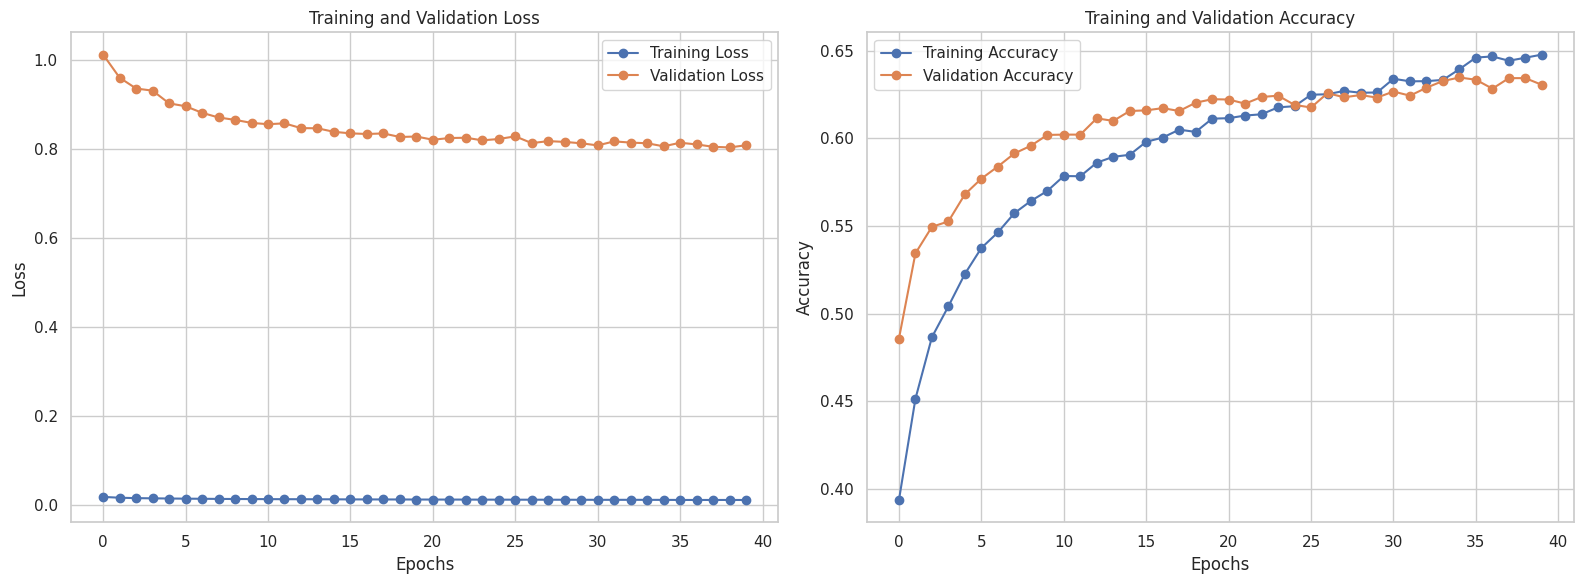

In [ ]:
plot_metrics(train_loss_history,val_loss_history,train_accuracy_history,val_accuracy_history)

### MLP results

In [ ]:
def test_dl_model(model,model_name="MLP", test_loader=testloader_embed, validation_loader=valloader_embed, device=device):
    """
    Evaluates a deep learning model and visualizes the confusion matrices.

    Args:
        model (nn.Module): The deep learning model.
        test_loader (DataLoader): DataLoader for the test dataset.
        validation_loader (DataLoader): DataLoader for the validation dataset.
        device (torch.device): Device to run the model on (CPU or GPU).
        sentiment_reverse_mapping (dict): Mapping from numerical labels to sentiment labels.
    """

    model.eval()  # Set the model to evaluation mode

    # Get predictions for test and validation sets
    test_label_pred, test_label_true = get_predictions(model, test_loader, device)
    validation_label_pred, validation_label_true = get_predictions(model, validation_loader, device)

    # Compute confusion matrices
    cm_test = confusion_matrix(test_label_true, test_label_pred)
    cm_validation = confusion_matrix(validation_label_true, validation_label_pred)

    # Set up the subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

    # Plot test confusion matrix
    sns.heatmap(cm_test, annot=True, fmt="d", cbar=True,
                xticklabels=list(sentiment_reverse_mapping.values()),
                yticklabels=list(sentiment_reverse_mapping.values()), ax=axes[0])
    axes[0].set_title("Test Confusion Matrix")
    axes[0].set_xlabel("Predicted Labels")
    axes[0].set_ylabel("True Labels")

    # Highlight the diagonal (correct predictions) for test set
    for i in range(cm_test.shape[0]):
        axes[0].add_patch(patches.Rectangle((i, i), 1, 1, fill=False, edgecolor="Coral", linewidth=2))

    # Plot validation confusion matrix
    sns.heatmap(cm_validation, annot=True, fmt="d", cbar=True,
                xticklabels=list(sentiment_reverse_mapping.values()),
                yticklabels=list(sentiment_reverse_mapping.values()), ax=axes[1])
    axes[1].set_title("Validation Confusion Matrix")
    axes[1].set_xlabel("Predicted Labels")
    axes[1].set_ylabel("True Labels")

    # Highlight the diagonal (correct predictions) for validation set
    for i in range(cm_validation.shape[0]):
        axes[1].add_patch(patches.Rectangle((i, i), 1, 1, fill=False, edgecolor="Coral", linewidth=2))

    # Show the plot
    plt.tight_layout()
    plt.show()
    test_report = classification_report(test_label_true, test_label_pred, target_names=list(sentiment_reverse_mapping.values()),output_dict=True)
    # Print classification reports for both test and validation
    print("Test Classification Report:")
    print(f"Overall Score {(np.trace(cm_test) / np.sum(cm_test))*100:.2f}%")
    print(classification_report(test_label_true, test_label_pred, target_names=list(sentiment_reverse_mapping.values())))
    validation_report = classification_report(validation_label_true, validation_label_pred, target_names=list(sentiment_reverse_mapping.values()),output_dict=True)
    print("Validation Classification Report:")
    print(f"Overall Score {(np.trace(cm_validation) / np.sum(cm_validation))*100:.2f}%")
    print(classification_report(validation_label_true, validation_label_pred, target_names=list(sentiment_reverse_mapping.values())))
    metrics = {
        "model_name": model_name,
        "test_accuracy": test_report["accuracy"],
        "test_precision": test_report["weighted avg"]["precision"],
        "test_recall": test_report["weighted avg"]["recall"],
        "test_f1-score": test_report["weighted avg"]["f1-score"],
        "validation_accuracy": validation_report["accuracy"],
        "validation_precision": validation_report["weighted avg"]["precision"],
        "validation_recall": validation_report["weighted avg"]["recall"],
        "validation_f1-score": validation_report["weighted avg"]["f1-score"],
    }
    return metrics

def get_predictions(model, data_loader, device):
    """
    Gets predictions from a deep learning model for a given data loader.

    Args:
        model (nn.Module): The deep learning model.
        data_loader (DataLoader): DataLoader for the dataset.
        device (torch.device): Device to run the model on (CPU or GPU).

    Returns:
        tuple: A tuple containing the predicted labels and true labels.
    """

    all_predictions = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation
        for batch in data_loader:
            inputs, labels= batch
            inputs,labels = inputs.to(device), labels.to(device)


            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_predictions, all_labels

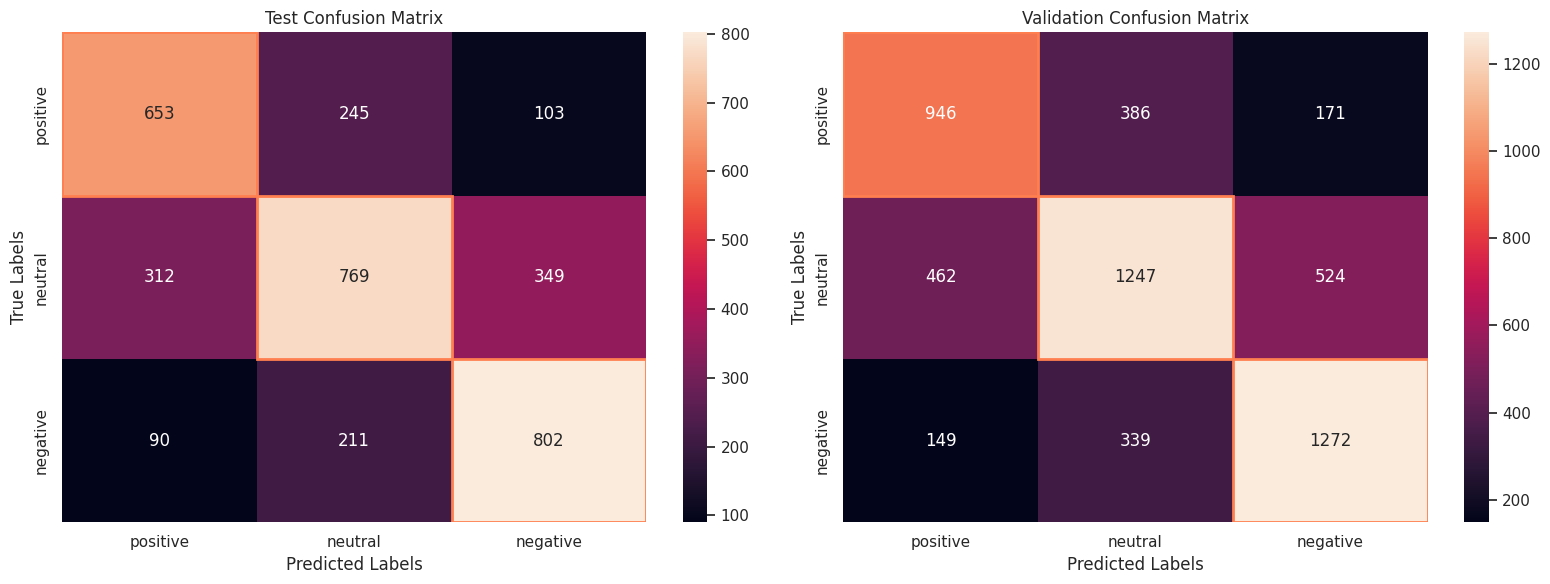

Test Classification Report:
Overall Score 62.93%
              precision    recall  f1-score   support

    positive       0.62      0.65      0.64      1001
     neutral       0.63      0.54      0.58      1430
    negative       0.64      0.73      0.68      1103

    accuracy                           0.63      3534
   macro avg       0.63      0.64      0.63      3534
weighted avg       0.63      0.63      0.63      3534

Validation Classification Report:
Overall Score 63.05%
              precision    recall  f1-score   support

    positive       0.61      0.63      0.62      1503
     neutral       0.63      0.56      0.59      2233
    negative       0.65      0.72      0.68      1760

    accuracy                           0.63      5496
   macro avg       0.63      0.64      0.63      5496
weighted avg       0.63      0.63      0.63      5496



In [ ]:
results.append(test_dl_model(model))

## Q4 : LLM - Finetuning (Bert)

### Model initialization (Bert + Linear(in_features=768, out_features=3)

In [ ]:
from transformers import BertForSequenceClassification
from torch.utils.data import DataLoader
import torch

# Load the pre-trained model for sequence classification
model_llm_before_finetune = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)  # 3 classes: positive, neutral, negative
model_llm_before_finetune.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:

model_llm = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)  # 3 classes: positive, neutral, negative

# Set the model to the correct device
model_llm.to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

### Helper functions to get predictions and testing

In [ ]:

def get_bert_predictions(model, data_loader, device,custom=False):
    """
    Gets predictions from a BertForSequenceClassification model.

    Args:
        model (BertForSequenceClassification): The BERT classifier model.
        data_loader (DataLoader): DataLoader for the dataset.
        device (torch.device): Device to run the model on (CPU or GPU).

    Returns:
        tuple: A tuple containing the predicted labels and true labels.
    """

    all_predictions = []
    all_labels = []

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for batch in data_loader:
            inputs, labels = batch
            inputs = {key: val.to(device) for key, val in inputs.items()}  # Move to GPU if available
            labels = labels.to(device)
            if custom:
              logits = model(**inputs)
            else:
              logits = model(**inputs).logits


            predictions = torch.argmax(logits, dim=1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_predictions, all_labels


In [ ]:
def test_llm_model(model,model_name, test_loader=testloader_tokenized, validation_loader=valloader_tokenized, device=device,custom=False):
    """
    Evaluates a BertForSequenceClassification model and visualizes confusion matrices.

    Args:
        model (BertForSequenceClassification): The BERT classifier model.
        test_loader (DataLoader): DataLoader for the test dataset.
        validation_loader (DataLoader): DataLoader for the validation dataset.
        device (torch.device): Device to run the model on (CPU or GPU).
        sentiment_reverse_mapping (dict): Mapping from numerical labels to sentiment labels.
    """

    # Get predictions for test and validation sets

    test_label_pred, test_label_true = get_bert_predictions(model, test_loader, device,custom=custom)
    validation_label_pred, validation_label_true = get_bert_predictions(model, validation_loader, device,custom=custom)

    # Compute confusion matrices
    cm_test = confusion_matrix(test_label_true, test_label_pred)
    cm_validation = confusion_matrix(validation_label_true, validation_label_pred)

    # Set up the subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot test confusion matrix
    sns.heatmap(cm_test, annot=True, fmt="d", cbar=True,
                xticklabels=list(sentiment_reverse_mapping.values()),
                yticklabels=list(sentiment_reverse_mapping.values()), ax=axes[0])
    axes[0].set_title("Test Confusion Matrix")
    axes[0].set_xlabel("Predicted Labels")
    axes[0].set_ylabel("True Labels")

    # Highlight the diagonal (correct predictions) for test set
    for i in range(cm_test.shape[0]):
        axes[0].add_patch(patches.Rectangle((i, i), 1, 1, fill=False, edgecolor="Coral", linewidth=2))

    # Plot validation confusion matrix
    sns.heatmap(cm_validation, annot=True, fmt="d", cbar=True,
                xticklabels=list(sentiment_reverse_mapping.values()),
                yticklabels=list(sentiment_reverse_mapping.values()), ax=axes[1])
    axes[1].set_title("Validation Confusion Matrix")
    axes[1].set_xlabel("Predicted Labels")
    axes[1].set_ylabel("True Labels")

    # Highlight the diagonal (correct predictions) for validation set
    for i in range(cm_validation.shape[0]):
        axes[1].add_patch(patches.Rectangle((i, i), 1, 1, fill=False, edgecolor="Coral", linewidth=2))

    plt.tight_layout()
    plt.show()
    test_report = classification_report(test_label_true, test_label_pred, target_names=list(sentiment_reverse_mapping.values()),output_dict=True)
    # Print classification reports
    print("Test Classification Report:")
    print(f"Overall Score {(np.trace(cm_test) / np.sum(cm_test)) * 100:.2f}%")
    print(classification_report(test_label_true, test_label_pred, target_names=list(sentiment_reverse_mapping.values())))
    validation_report = classification_report(validation_label_true, validation_label_pred, target_names=list(sentiment_reverse_mapping.values()),output_dict=True)
    print("Validation Classification Report:")
    print(f"Overall Score {(np.trace(cm_validation) / np.sum(cm_validation)) * 100:.2f}%")
    print(classification_report(validation_label_true, validation_label_pred, target_names=list(sentiment_reverse_mapping.values())))
    metrics = {
        "model_name": model_name,
        "test_accuracy": test_report["accuracy"],
        "test_precision": test_report["weighted avg"]["precision"],
        "test_recall": test_report["weighted avg"]["recall"],
        "test_f1-score": test_report["weighted avg"]["f1-score"],
        "validation_accuracy": validation_report["accuracy"],
        "validation_precision": validation_report["weighted avg"]["precision"],
        "validation_recall": validation_report["weighted avg"]["recall"],
        "validation_f1-score": validation_report["weighted avg"]["f1-score"],
    }
    return metrics

### Model before finetuning

LLM before tuning


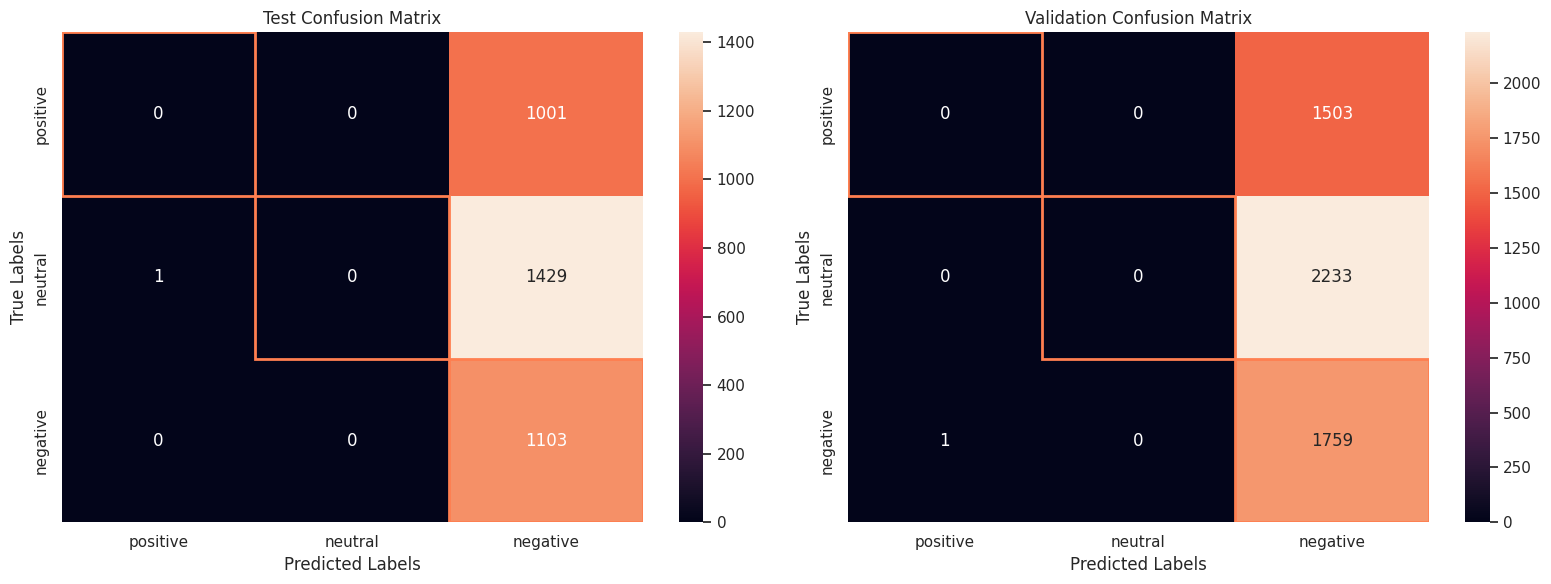

Test Classification Report:
Overall Score 31.21%
              precision    recall  f1-score   support

    positive       0.00      0.00      0.00      1001
     neutral       0.00      0.00      0.00      1430
    negative       0.31      1.00      0.48      1103

    accuracy                           0.31      3534
   macro avg       0.10      0.33      0.16      3534
weighted avg       0.10      0.31      0.15      3534

Validation Classification Report:
Overall Score 32.01%
              precision    recall  f1-score   support

    positive       0.00      0.00      0.00      1503
     neutral       0.00      0.00      0.00      2233
    negative       0.32      1.00      0.48      1760

    accuracy                           0.32      5496
   macro avg       0.11      0.33      0.16      5496
weighted avg       0.10      0.32      0.16      5496



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [ ]:
print("LLM before tuning")
results.append(test_llm_model(model_llm_before_finetune,"Not finetuned LLM"))

### FineTuning

#### Initializing

In [ ]:
optimizer = Adam(model_llm.parameters(), lr=2e-5)  # Fine-tuning BERT typically uses a low LR
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

criterion = nn.CrossEntropyLoss()

# Training settings
num_epochs = 10
patience = 5
train_loss_history = []
val_loss_history = []
train_accuracy_history = []
val_accuracy_history = []

In [ ]:
def train_model(model, train_loader=train_loader_tokenized, val_loader=valloader_tokenized, device=device, num_epochs=10, patience=patience, lr=0.001, bad_patience=3, checkpoint_folder='checkpoints',custom=False):
    os.makedirs(checkpoint_folder, exist_ok=True)
    best_val_loss = float('inf')
    epochs_since_improvement = 0
    best_epoch = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            inputs, labels = batch
            inputs = {key: val.to(device) for key, val in inputs.items()}
            labels = labels.to(device)

            optimizer.zero_grad()
            if custom:
              outputs= model(**inputs)
            else:
              outputs = model(**inputs).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / len(train_loader)
        train_loss_history.append(epoch_train_loss)
        epoch_train_accuracy = correct_train / total_train
        train_accuracy_history.append(epoch_train_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_train_loss:.4f}, Training Accuracy: {epoch_train_accuracy:.4f}")

        # Validation
        model.eval()
        val_running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                inputs, labels = batch
                inputs = {key: val.to(device) for key, val in inputs.items()}
                labels = labels.to(device)
                if custom:
                  outputs = model(**inputs)
                else:
                  outputs = model(**inputs).logits
                val_running_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_running_loss /= len(val_loader)
        val_loss_history.append(val_running_loss)
        scheduler.step(val_running_loss)

        if val_running_loss < best_val_loss:
            best_val_loss = val_running_loss
            epochs_since_improvement = 0
            best_epoch = epoch + 1
            torch.save(model.state_dict(), os.path.join(checkpoint_folder, f'best_model_epoch_{epoch+1}.pth'))
            print("Validation loss improved. Saving model checkpoint.")
        else:
            epochs_since_improvement += 1
            if epochs_since_improvement >= patience:
                print(f"Early stopping triggered. No improvement in {patience} epochs.")
                break

            if val_running_loss > best_val_loss and epochs_since_improvement >= bad_patience:
                print("Validation loss increased. Rolling back to best model.")
                model.load_state_dict(torch.load(os.path.join(checkpoint_folder, f'best_model_epoch_{best_epoch}.pth')))
                optimizer.zero_grad()
                epochs_since_improvement = 0

        epoch_val_accuracy = correct_val / total_val
        val_accuracy_history.append(epoch_val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_running_loss:.4f}, Validation Accuracy: {epoch_val_accuracy:.4f}")
        print(f"Current LR: {optimizer.param_groups[0]['lr']}")

#### Training

In [ ]:
train_model(model_llm)

Epoch 1/10 - Training: 100%|██████████| 344/344 [05:25<00:00,  1.06it/s]


Epoch [1/10], Training Loss: 0.6791, Training Accuracy: 0.7086


Epoch 1/10 - Validation: 100%|██████████| 22/22 [00:16<00:00,  1.34it/s]


Validation loss improved. Saving model checkpoint.
Epoch [1/10], Validation Loss: 0.5967, Validation Accuracy: 0.7635
Current LR: 2e-05


Epoch 2/10 - Training: 100%|██████████| 344/344 [05:25<00:00,  1.06it/s]


Epoch [2/10], Training Loss: 0.4982, Training Accuracy: 0.8020


Epoch 2/10 - Validation: 100%|██████████| 22/22 [00:16<00:00,  1.34it/s]


Validation loss improved. Saving model checkpoint.
Epoch [2/10], Validation Loss: 0.5662, Validation Accuracy: 0.7737
Current LR: 2e-05


Epoch 3/10 - Training: 100%|██████████| 344/344 [05:24<00:00,  1.06it/s]


Epoch [3/10], Training Loss: 0.3933, Training Accuracy: 0.8503


Epoch 3/10 - Validation: 100%|██████████| 22/22 [00:16<00:00,  1.34it/s]


Epoch [3/10], Validation Loss: 0.5759, Validation Accuracy: 0.7726
Current LR: 2e-05


Epoch 4/10 - Training: 100%|██████████| 344/344 [05:24<00:00,  1.06it/s]


Epoch [4/10], Training Loss: 0.2827, Training Accuracy: 0.8968


Epoch 4/10 - Validation: 100%|██████████| 22/22 [00:16<00:00,  1.34it/s]


Epoch [4/10], Validation Loss: 0.6327, Validation Accuracy: 0.7764
Current LR: 2e-05


Epoch 5/10 - Training: 100%|██████████| 344/344 [05:24<00:00,  1.06it/s]


Epoch [5/10], Training Loss: 0.1952, Training Accuracy: 0.9316


Epoch 5/10 - Validation: 100%|██████████| 22/22 [00:16<00:00,  1.34it/s]
<ipython-input-120-a2ad2a045852>:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_

Validation loss increased. Rolling back to best model.
Epoch [5/10], Validation Loss: 0.7786, Validation Accuracy: 0.7669
Current LR: 2e-05


Epoch 6/10 - Training: 100%|██████████| 344/344 [05:24<00:00,  1.06it/s]


Epoch [6/10], Training Loss: 0.3838, Training Accuracy: 0.8539


Epoch 6/10 - Validation: 100%|██████████| 22/22 [00:16<00:00,  1.33it/s]


Epoch [6/10], Validation Loss: 0.5948, Validation Accuracy: 0.7764
Current LR: 2.0000000000000003e-06


Epoch 7/10 - Training: 100%|██████████| 344/344 [05:24<00:00,  1.06it/s]


Epoch [7/10], Training Loss: 0.2707, Training Accuracy: 0.9038


Epoch 7/10 - Validation: 100%|██████████| 22/22 [00:16<00:00,  1.34it/s]


Epoch [7/10], Validation Loss: 0.6478, Validation Accuracy: 0.7778
Current LR: 2.0000000000000003e-06


Epoch 8/10 - Training: 100%|██████████| 344/344 [05:24<00:00,  1.06it/s]


Epoch [8/10], Training Loss: 0.2496, Training Accuracy: 0.9119


Epoch 8/10 - Validation: 100%|██████████| 22/22 [00:16<00:00,  1.34it/s]


Validation loss increased. Rolling back to best model.
Epoch [8/10], Validation Loss: 0.6599, Validation Accuracy: 0.7747
Current LR: 2.0000000000000003e-06


Epoch 9/10 - Training: 100%|██████████| 344/344 [05:25<00:00,  1.06it/s]


Epoch [9/10], Training Loss: 0.3725, Training Accuracy: 0.8594


Epoch 9/10 - Validation: 100%|██████████| 22/22 [00:16<00:00,  1.34it/s]


Epoch [9/10], Validation Loss: 0.5743, Validation Accuracy: 0.7800
Current LR: 2.0000000000000003e-06


Epoch 10/10 - Training: 100%|██████████| 344/344 [05:25<00:00,  1.06it/s]


Epoch [10/10], Training Loss: 0.3476, Training Accuracy: 0.8700


Epoch 10/10 - Validation: 100%|██████████| 22/22 [00:16<00:00,  1.30it/s]

Epoch [10/10], Validation Loss: 0.5919, Validation Accuracy: 0.7822
Current LR: 2.0000000000000004e-07


### Results after Finetuning LLM

After finetuning


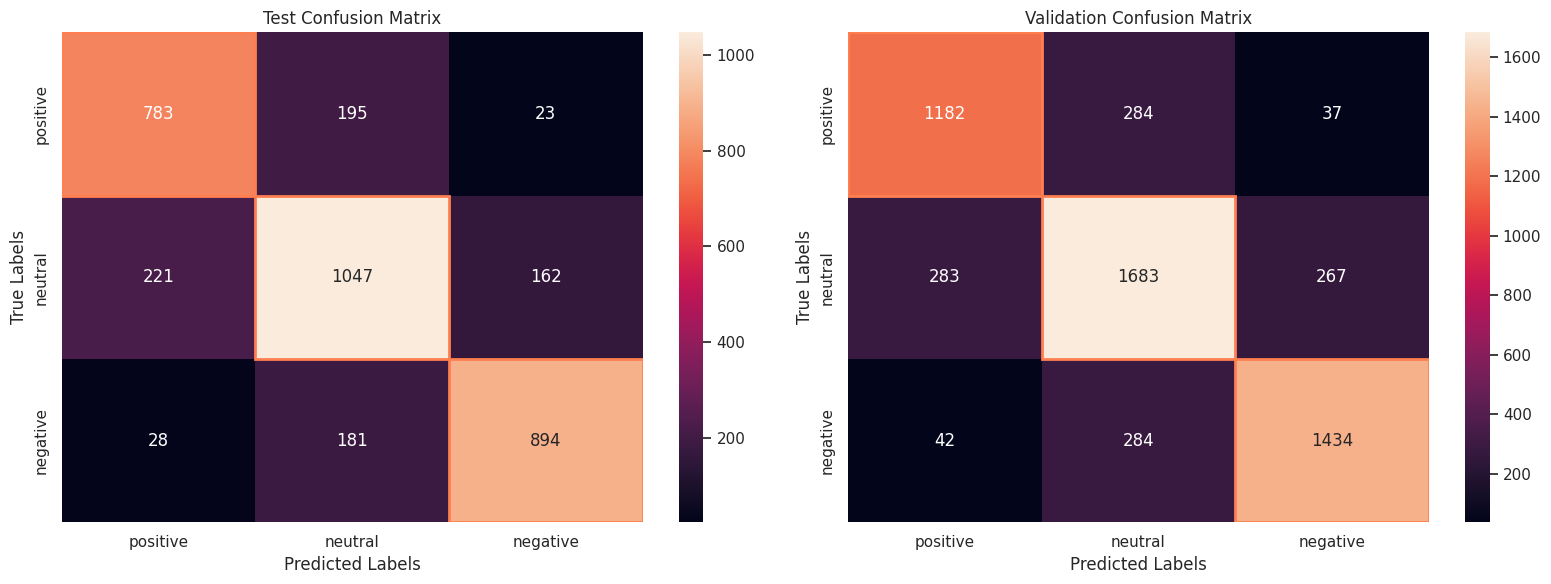

Test Classification Report:
Overall Score 77.08%
              precision    recall  f1-score   support

    positive       0.76      0.78      0.77      1001
     neutral       0.74      0.73      0.73      1430
    negative       0.83      0.81      0.82      1103

    accuracy                           0.77      3534
   macro avg       0.77      0.77      0.77      3534
weighted avg       0.77      0.77      0.77      3534

Validation Classification Report:
Overall Score 78.22%
              precision    recall  f1-score   support

    positive       0.78      0.79      0.79      1503
     neutral       0.75      0.75      0.75      2233
    negative       0.83      0.81      0.82      1760

    accuracy                           0.78      5496
   macro avg       0.79      0.78      0.79      5496
weighted avg       0.78      0.78      0.78      5496



In [ ]:
print("After finetuning")
results.append(test_llm_model(model_llm,"Finetuned LLM"))

In [ ]:
df_results = pd.DataFrame(results)
df_results

,model_name,test_accuracy,test_precision,test_recall,test_f1-score,validation_accuracy,validation_precision,validation_recall,validation_f1-score
0,Decision Tree,0.431239,0.431874,0.431239,0.431504,0.452693,0.453606,0.452693,0.453108
1,Random Forest,0.556876,0.571784,0.556876,0.548080,0.557860,0.569378,0.557860,0.548863
2,Logistic Regression,0.648840,0.650663,0.648840,0.649422,0.656841,0.659773,0.656841,0.657410
3,KNeighbors(k=30),0.487832,0.487682,0.487832,0.481937,0.499090,0.499362,0.499090,0.493382
4,Gaussian Naive Bayes,0.359366,0.411083,0.359366,0.298049,0.356987,0.417391,0.356987,0.298291
5,MLP,0.626769,0.628734,0.626769,0.627360,0.627729,0.630017,0.627729,0.628374
6,Not finetuned LLM,0.770798,0.771227,0.770798,0.770929,0.782205,0.782488,0.782205,0.782331
7,Finetuned LLM,0.770798,0.771227,0.770798,0.770929,0.782205,0.782488,0.782205,0.782331


<ipython-input-133-efefd3ebb993>:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_xticklabels(df_results["model_name"], rotation=45)
<ipython-input-133-efefd3ebb993>:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_xticklabels(df_results["model_name"], rotation=45)
<ipython-input-133-efefd3ebb993>:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_xticklabels(df_results["model_name"], rotation=45)
<ipython-input-133-efefd3ebb993>:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_xticklabels(df_results["model_name"], rotation=45)
<ipython-input-133-efefd3ebb993>:19: UserWarning: set_ticklabels() s

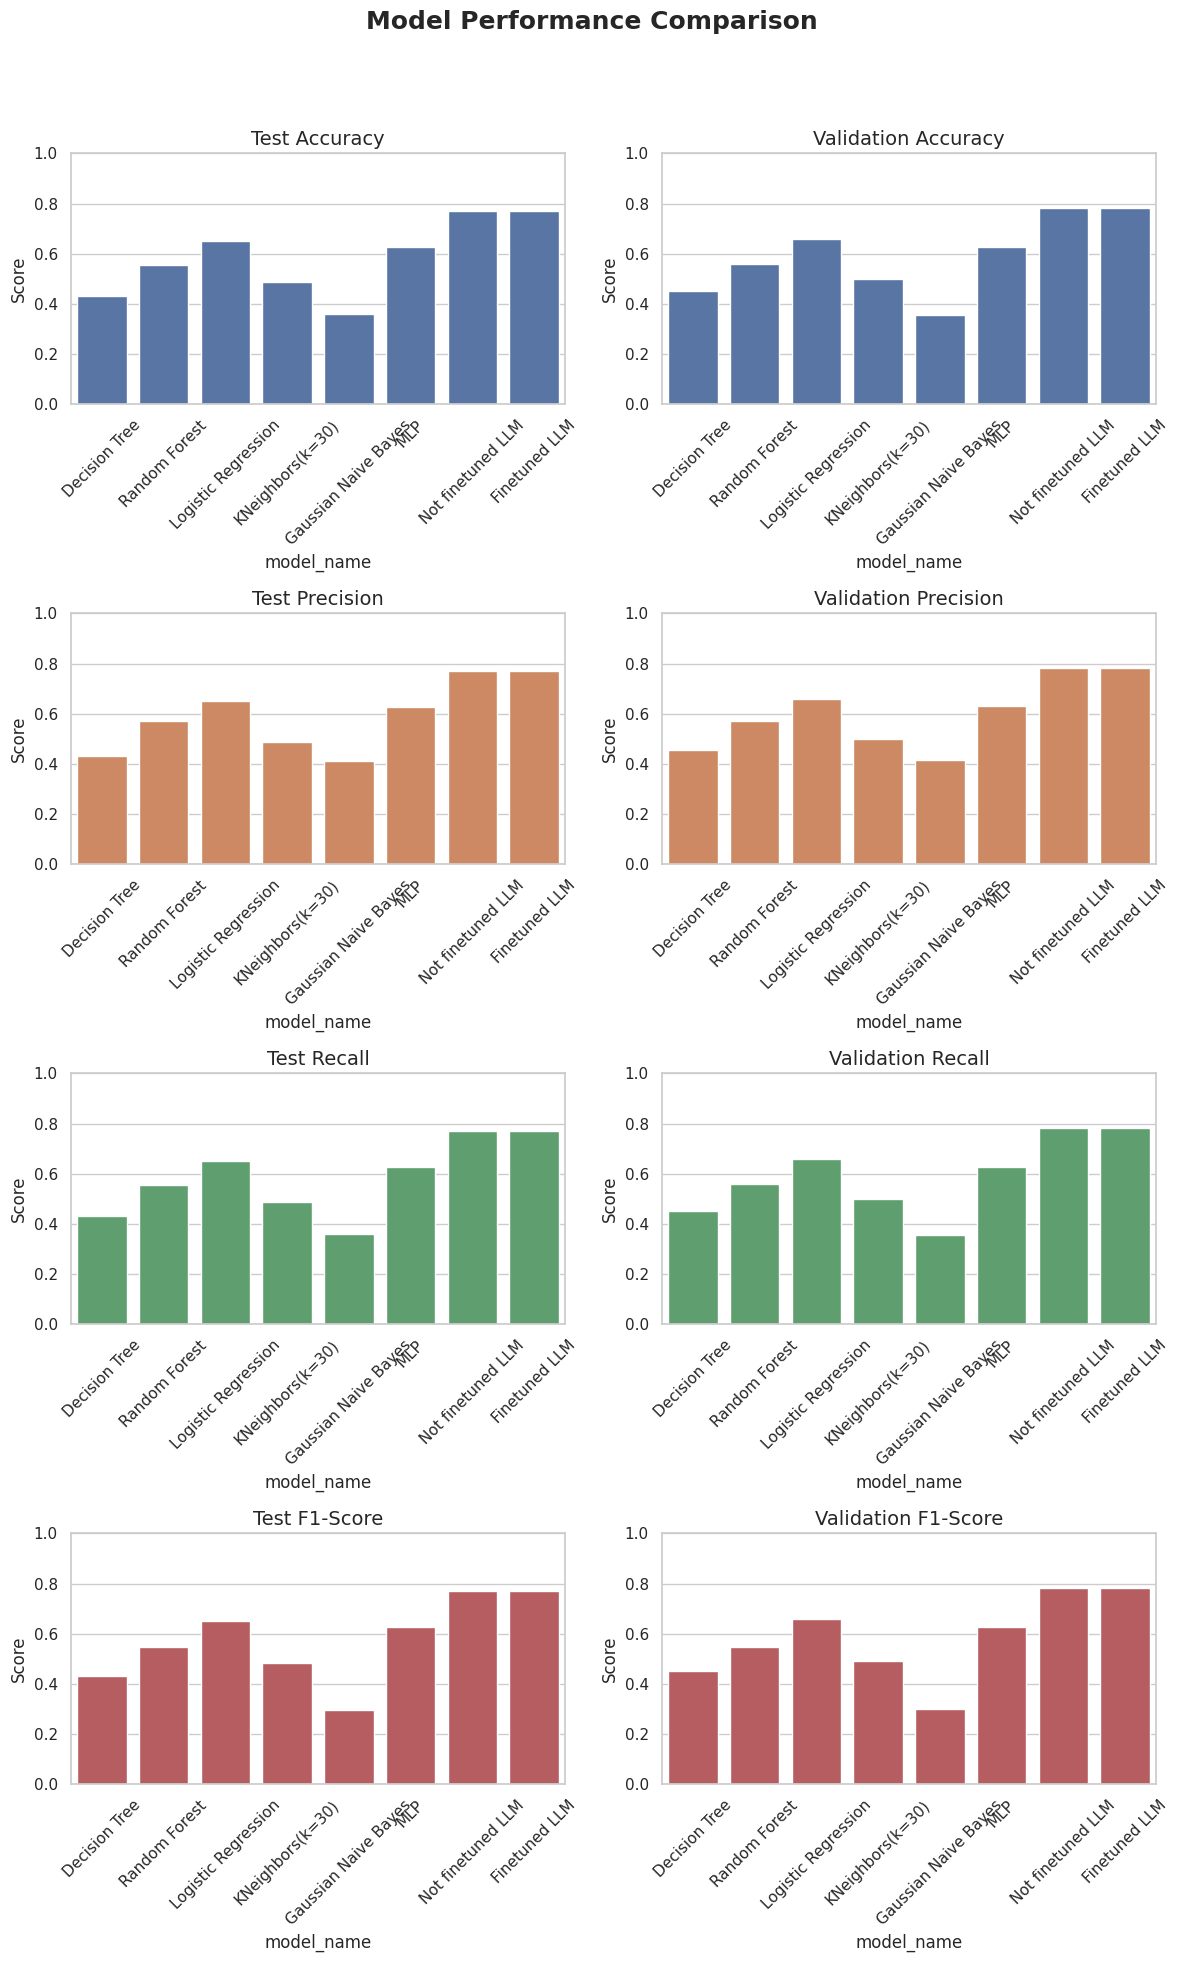

The best model is Not finetuned LLM with a test accuracy of 77.08%


In [ ]:
plot_model_metrics(df_results)

## Q7 : Finetuning with LORA

### Initialization

In [ ]:
!pip install peft

In [ ]:
from peft import get_peft_model, LoraConfig, TaskType
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,  # Sequence classification
    r=8,  # Rank of the low-rank matrices
    lora_alpha=32,  # Scaling factor
    lora_dropout=0.1,  # Dropout for LoRA layers
    bias="all"
)

model_bert_lora = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
model_bert_lora = get_peft_model(model_bert_lora, lora_config)
model_bert_lora.to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default

### Training Lora

In [ ]:
optimizer = Adam(model_bert_lora.parameters(), lr=0.00001)  # Fine-tuning BERT typically uses a low LR
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

criterion = nn.CrossEntropyLoss()

# Training settings
num_epochs = 10
patience = 3
train_loss_history = []
val_loss_history = []
train_accuracy_history = []
val_accuracy_history = []

In [ ]:
train_model(model_bert_lora)

Epoch 1/10 - Training: 100%|██████████| 344/344 [04:07<00:00,  1.39it/s]


Epoch [1/10], Training Loss: 1.0911, Training Accuracy: 0.3919


Epoch 1/10 - Validation: 100%|██████████| 22/22 [00:17<00:00,  1.28it/s]


Validation loss improved. Saving model checkpoint.
Epoch [1/10], Validation Loss: 1.0790, Validation Accuracy: 0.4061
Current LR: 1e-05


Epoch 2/10 - Training: 100%|██████████| 344/344 [04:06<00:00,  1.40it/s]


Epoch [2/10], Training Loss: 1.0739, Training Accuracy: 0.4054


Epoch 2/10 - Validation: 100%|██████████| 22/22 [00:17<00:00,  1.28it/s]


Validation loss improved. Saving model checkpoint.
Epoch [2/10], Validation Loss: 1.0413, Validation Accuracy: 0.4432
Current LR: 1e-05


Epoch 3/10 - Training: 100%|██████████| 344/344 [04:06<00:00,  1.40it/s]


Epoch [3/10], Training Loss: 0.9584, Training Accuracy: 0.5242


Epoch 3/10 - Validation: 100%|██████████| 22/22 [00:17<00:00,  1.29it/s]


Validation loss improved. Saving model checkpoint.
Epoch [3/10], Validation Loss: 0.8406, Validation Accuracy: 0.6126
Current LR: 1e-05


Epoch 4/10 - Training: 100%|██████████| 344/344 [04:06<00:00,  1.40it/s]


Epoch [4/10], Training Loss: 0.7956, Training Accuracy: 0.6438


Epoch 4/10 - Validation: 100%|██████████| 22/22 [00:17<00:00,  1.29it/s]


Validation loss improved. Saving model checkpoint.
Epoch [4/10], Validation Loss: 0.7189, Validation Accuracy: 0.6920
Current LR: 1e-05


Epoch 5/10 - Training: 100%|██████████| 344/344 [04:06<00:00,  1.40it/s]


Epoch [5/10], Training Loss: 0.7222, Training Accuracy: 0.6842


Epoch 5/10 - Validation: 100%|██████████| 22/22 [00:17<00:00,  1.29it/s]


Validation loss improved. Saving model checkpoint.
Epoch [5/10], Validation Loss: 0.6704, Validation Accuracy: 0.7207
Current LR: 1e-05


Epoch 6/10 - Training: 100%|██████████| 344/344 [04:05<00:00,  1.40it/s]


Epoch [6/10], Training Loss: 0.6845, Training Accuracy: 0.7079


Epoch 6/10 - Validation: 100%|██████████| 22/22 [00:17<00:00,  1.28it/s]


Validation loss improved. Saving model checkpoint.
Epoch [6/10], Validation Loss: 0.6495, Validation Accuracy: 0.7329
Current LR: 1e-05


Epoch 7/10 - Training: 100%|██████████| 344/344 [04:06<00:00,  1.40it/s]


Epoch [7/10], Training Loss: 0.6644, Training Accuracy: 0.7179


Epoch 7/10 - Validation: 100%|██████████| 22/22 [00:17<00:00,  1.29it/s]


Validation loss improved. Saving model checkpoint.
Epoch [7/10], Validation Loss: 0.6279, Validation Accuracy: 0.7413
Current LR: 1e-05


Epoch 8/10 - Training: 100%|██████████| 344/344 [04:06<00:00,  1.40it/s]


Epoch [8/10], Training Loss: 0.6482, Training Accuracy: 0.7247


Epoch 8/10 - Validation: 100%|██████████| 22/22 [00:17<00:00,  1.29it/s]


Validation loss improved. Saving model checkpoint.
Epoch [8/10], Validation Loss: 0.6204, Validation Accuracy: 0.7476
Current LR: 1e-05


Epoch 9/10 - Training: 100%|██████████| 344/344 [04:06<00:00,  1.40it/s]


Epoch [9/10], Training Loss: 0.6366, Training Accuracy: 0.7324


Epoch 9/10 - Validation: 100%|██████████| 22/22 [00:17<00:00,  1.29it/s]


Validation loss improved. Saving model checkpoint.
Epoch [9/10], Validation Loss: 0.6160, Validation Accuracy: 0.7451
Current LR: 1e-05


Epoch 10/10 - Training:  15%|█▌        | 53/344 [00:38<03:29,  1.39it/s]

In [ ]:
train_model(model_bert_lora,num_epochs=5)

Epoch 1/5 - Training: 100%|██████████| 344/344 [04:06<00:00,  1.39it/s]


Epoch [1/5], Training Loss: 0.5929, Training Accuracy: 0.7530


Epoch 1/5 - Validation: 100%|██████████| 22/22 [00:17<00:00,  1.29it/s]


Validation loss improved. Saving model checkpoint.
Epoch [1/5], Validation Loss: 0.5777, Validation Accuracy: 0.7567
Current LR: 1e-05


Epoch 2/5 - Training:   1%|          | 2/344 [00:01<04:21,  1.31it/s]


KeyboardInterrupt: 

### Training visualization

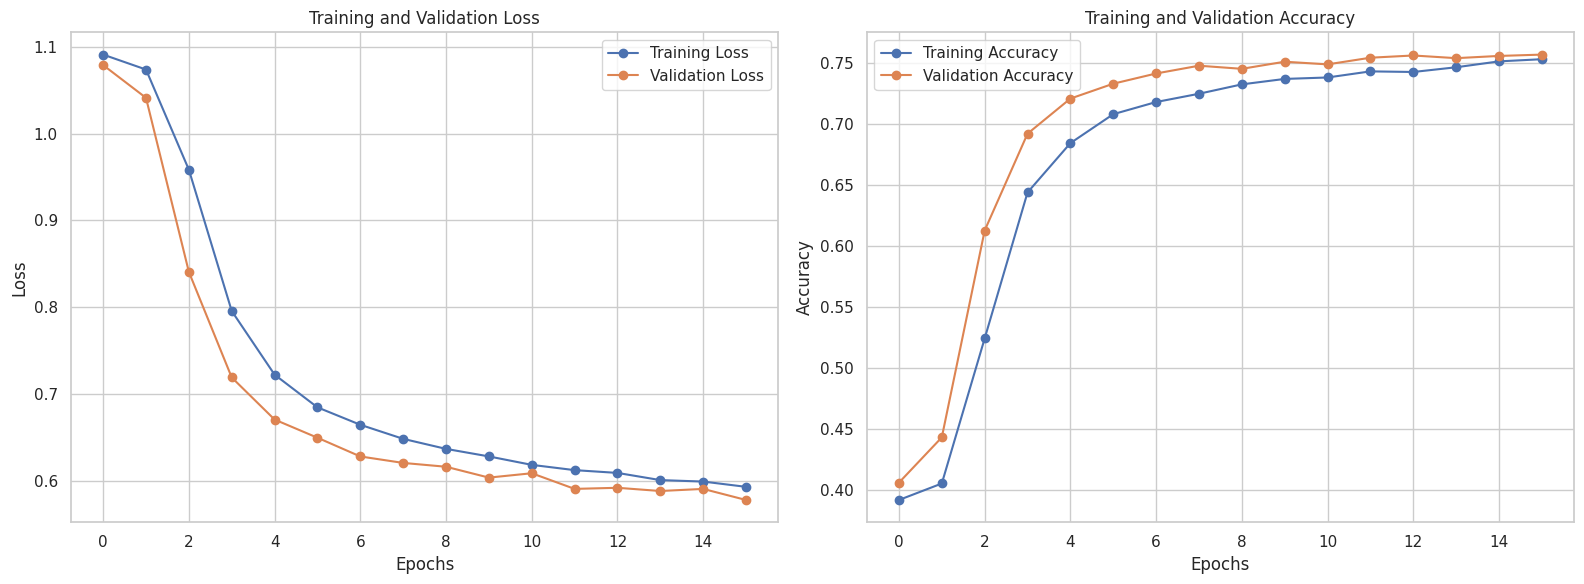

In [ ]:
plot_metrics(train_loss_history,val_loss_history,train_accuracy_history,val_accuracy_history)

### Lora Results

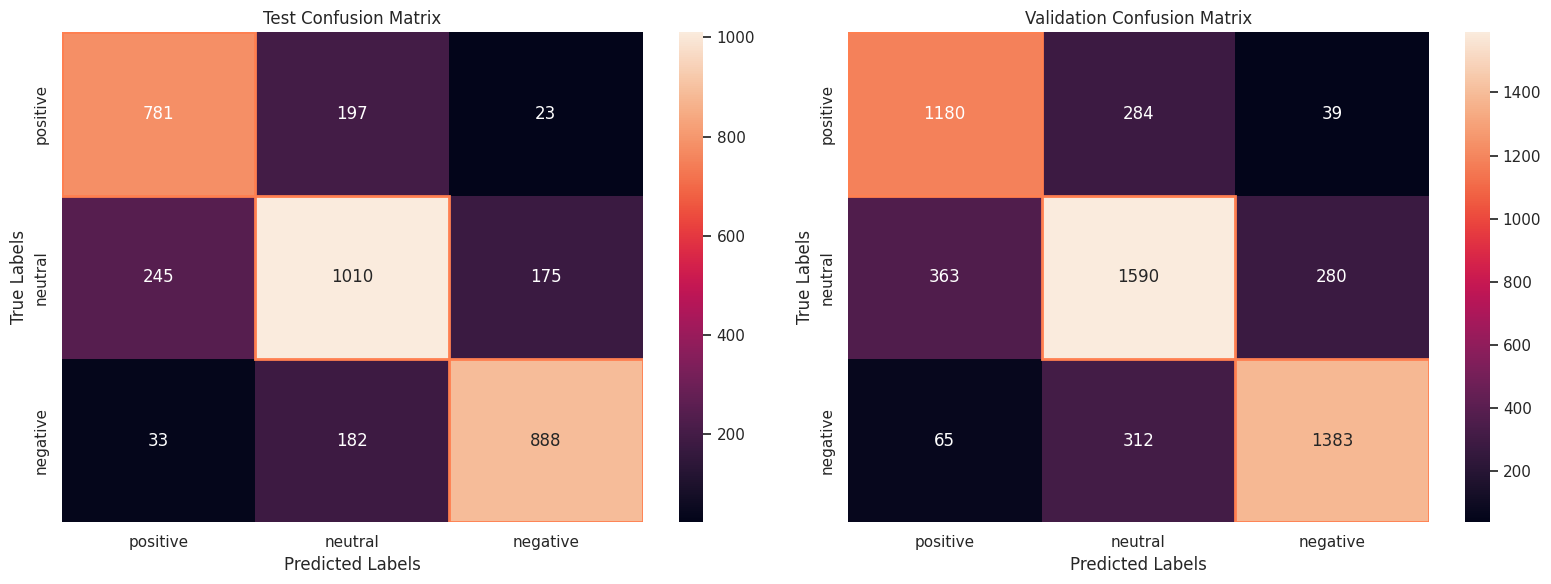

Test Classification Report:
Overall Score 75.81%
              precision    recall  f1-score   support

    positive       0.74      0.78      0.76      1001
     neutral       0.73      0.71      0.72      1430
    negative       0.82      0.81      0.81      1103

    accuracy                           0.76      3534
   macro avg       0.76      0.76      0.76      3534
weighted avg       0.76      0.76      0.76      3534

Validation Classification Report:
Overall Score 75.56%
              precision    recall  f1-score   support

    positive       0.73      0.79      0.76      1503
     neutral       0.73      0.71      0.72      2233
    negative       0.81      0.79      0.80      1760

    accuracy                           0.76      5496
   macro avg       0.76      0.76      0.76      5496
weighted avg       0.76      0.76      0.76      5496



In [ ]:
results.append(test_llm_model(model_bert_lora,"llm with lora"))

<ipython-input-178-8a6969d2296e>:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, i].set_xticklabels(df_results["model_name"], rotation=90,fontsize= 10)
<ipython-input-178-8a6969d2296e>:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, i].set_xticklabels(df_results["model_name"], rotation=90,fontsize = 10)
<ipython-input-178-8a6969d2296e>:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, i].set_xticklabels(df_results["model_name"], rotation=90,fontsize= 10)
<ipython-input-178-8a6969d2296e>:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, i].set_xticklabels(df_results["model_name"], rotation=90,fontsize = 10)
<ipython-input

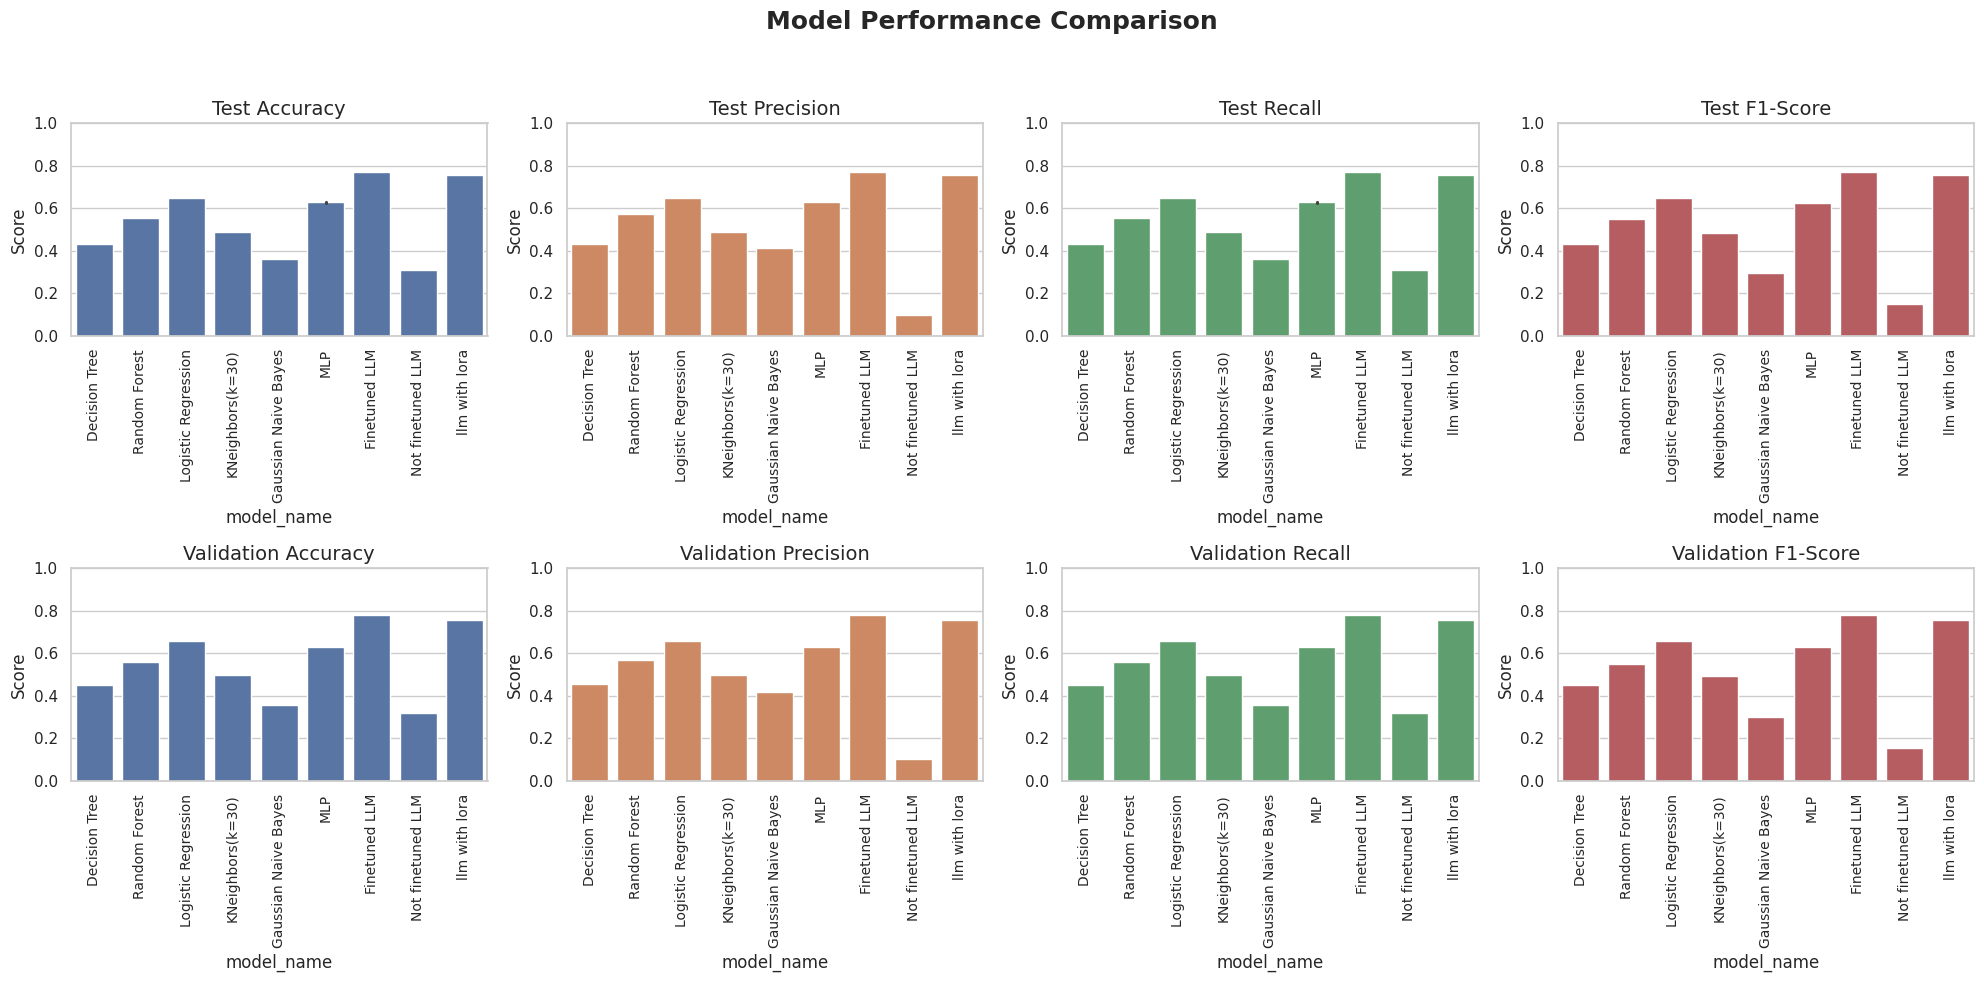

The best model is Finetuned LLM with a test accuracy of 77.08%


In [ ]:
plot_model_metrics(pd.DataFrame(results))